# Credit Underwriting Machine Learning Project

In [436]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import chi2_contingency

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, average_precision_score, balanced_accuracy_score, 
                             f1_score, make_scorer, precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, StratifiedKFold, 
                                     cross_validate, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

## Data importation and preparation

In [437]:
EXCEL_FILE_PATH = 'data.xlsx'

SHEET_NAME_APP = 'application_data'
SHEET_NAME_LOAN = 'loan_performance'

# Read the specified sheet into a DataFrame
df_app = pd.read_excel(EXCEL_FILE_PATH, sheet_name=SHEET_NAME_APP)
df_loan = pd.read_excel(EXCEL_FILE_PATH, sheet_name=SHEET_NAME_LOAN)

# Specify the path to save the CSV file
CSV_FILE_PATH_APP = 'app.csv'
CSV_FILE_PATH_LOAN = 'loan.csv'

# Save the DataFrame to a CSV file
df_app.to_csv(CSV_FILE_PATH_APP, index=False)
df_loan.to_csv(CSV_FILE_PATH_LOAN, index=False)

print(f"Sheet '{SHEET_NAME_APP}' from '{EXCEL_FILE_PATH}' has been saved as '{CSV_FILE_PATH_APP}'")
print(f"Sheet '{SHEET_NAME_LOAN}' from '{EXCEL_FILE_PATH}' has been saved as '{CSV_FILE_PATH_LOAN}'")

Sheet 'application_data' from 'data.xlsx' has been saved as 'app.csv'
Sheet 'loan_performance' from 'data.xlsx' has been saved as 'loan.csv'


/opt/homebrew/anaconda3/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [438]:
df_app.head()

,customer_id,amount_requested,birth_date,status,residence_rent_or_own,monthly_rent_amount,bank_account_direct_deposit,application_when,loan_duration,payment_ach,...,payment_frequency,home_phone_type,other_phone_type,how_use_money,monthly_income_amount,raw_l2c_score,raw_FICO_telecom,raw_FICO_retail,raw_FICO_bank_card,raw_FICO_money
0,9ece67d6c5,500,1991-08-21,Approved,True,0,True,2010-10-16 14:06:05,3,True,...,Semi-monthly,Mobile,NaN,Other,1560,614,574,600,656,561
1,5c2c402094,500,1990-07-24,Approved,True,0,False,2010-10-17 13:01:53,6,True,...,Bi-weekly,Mobile,NaN,Other,900,708,501,550,651,563
2,e6254cad30,400,1980-09-13,Approved,True,620,True,2010-10-17 19:52:34,6,True,...,Bi-weekly,Mobile,NaN,Other,1434,687,522,561,661,598
3,49fb42f51d,500,1976-09-10,Approved,False,785,False,2010-10-18 07:05:00,4,True,...,Bi-weekly,Mobile,NaN,Other,1600,616,560,552,634,591
4,195fbe5739,300,1979-12-01,Approved,True,700,True,2010-10-19 10:58:40,4,True,...,Bi-weekly,Mobile,Home,Other,1360,681,603,654,659,636


In [439]:
df_loan.head()

,idLoan,flgGood
0,0DBA6B011D-01,Bad
1,96ACBBA7ED-01,Bad
2,289421D82A-01,Bad
3,9ECE67D6C5-01,Good
4,5C2C402094-01,Bad


In [440]:
# Convert the idLoan column from df_loan to lowercase to match format from df_app
df_loan['idLoan'] = df_loan['idLoan'].str.lower()

In [441]:
df_loan.head()

,idLoan,flgGood
0,0dba6b011d-01,Bad
1,96acbba7ed-01,Bad
2,289421d82a-01,Bad
3,9ece67d6c5-01,Good
4,5c2c402094-01,Bad


### Dealing with customers that have asked more than 1 loan

In [442]:
df_loan['idLoan'].map(lambda x: x[:-3]).value_counts().sort_values(ascending=False)

b3f9914dbb    2
d7001aa34e    2
b86063bf54    2
4dad1a9de6    2
70409dc892    2
             ..
42b0fb0e51    1
f0e8cb9b44    1
5e909d6057    1
1a206ffeee    1
fc6f1f5dd6    1
Name: idLoan, Length: 1269, dtype: int64

In [443]:
(df_loan['idLoan'].map(lambda x: x[:-3]).value_counts().sort_values(ascending=False) > 1).sum()

16

In [444]:
ids_of_customers_with_2_loans = list(df_loan.loc[df_loan.idLoan.str.contains('-02'), 'idLoan'].map(lambda loan_id: loan_id[:-3]).values)
ids_of_customers_with_2_loans

['4dad1a9de6',
 'b1a2837477',
 'b86063bf54',
 'dfb2f1ec63',
 'b6514d8366',
 'd06841c8cf',
 'ae03151fee',
 '70409dc892',
 'b4f2e3f3a3',
 'b3f9914dbb',
 'a15e74274b',
 '418abe2912',
 '34ddb612ce',
 'd7001aa34e',
 '0f9800a7ff',
 '2ac47a61e0']

In [445]:
df_loan[df_loan.idLoan.map(lambda loan_id: loan_id[:-3]).isin(ids_of_customers_with_2_loans)]

,idLoan,flgGood
6,ae03151fee-01,Good
23,dfb2f1ec63-01,Good
33,d06841c8cf-01,Good
43,b4f2e3f3a3-01,Good
60,b86063bf54-01,Good
86,2ac47a61e0-01,Good
88,70409dc892-01,Good
120,b3f9914dbb-01,Good
121,418abe2912-01,Good
123,d7001aa34e-01,Good


16 customers have asked for 2 credits, while all others have asked for only one.

For those customers, we need to decide on a strategy for how to flag them. Indeed, if such a customer has one of their loans flagged as good and the other one as bad (e.g., customer b1a2837477), how to flag the customer?
One strategy would be to duplicate the corresponding row in df_app: one for each application. The problem is that it could introduce some noise if one loan is good and the other is bad, making it difficult for the model to learn.
Another strategy would be to drop (from both datasets) the customers who've made 2 loans, and only keep those who've made 1 loan. The issue here is that we already have a very limited number of records, so we might want to use all the data available.
Finally, what we can do is to change the label of those customers based on the outcomes of their 2 loans: if at least one of them was flagged as bad, then flag the customer as bad. Otherwise, flag it as good.

Since there are only 3 customers who've asked 2 loans and for which one of them was good and the other one was bad, we can drop only those specific customers, and the resulting loss of data will remain very limited.

In [446]:
# We could automate, but here it's easier to just hardcode since there are only 3 customers concerned
conflicting_customers = ['b1a2837477', 'dfb2f1ec63', 'b3f9914dbb']

df_loan['idLoan'] = df_loan['idLoan'].map(lambda x: x[:-3])

In [447]:
df_loan

,idLoan,flgGood
0,0dba6b011d,Bad
1,96acbba7ed,Bad
2,289421d82a,Bad
3,9ece67d6c5,Good
4,5c2c402094,Bad
...,...,...
1280,2ac47a61e0,Good
1281,6083264819,Good
1282,f662a12c25,Good
1283,42b0fb0e51,Good


In [448]:
# Drop from df_loan the conflicting customers
df_loan = df_loan.drop(df_loan.loc[df_loan['idLoan'].isin(conflicting_customers)].index)

We now have some duplicates in df_loan:

In [449]:
len(df_loan)

1279

In [450]:
df_loan['idLoan'].nunique()

1266

Let's drop the duplicates:

In [451]:
df_loan = df_loan.drop_duplicates(subset=['idLoan'])

In [452]:
# sanity check
assert df_loan['idLoan'].nunique() == len(df_loan)

In [453]:
# Drop from df_app the conflicting customers
df_app = df_app.drop(df_app.loc[df_app['customer_id'].isin(conflicting_customers)].index)

In [454]:
# sanity check
assert df_app['customer_id'].nunique() == len(df_app)

At this point, df_app only contains applications from customers customers who've asked exactly 1 loan or those who've asked 2 loans but for which both were flagged the same way. Additionally, both dataset contains only unique values.

### Merging df_app and df_loan

In [455]:
len(df_loan)

1266

In [456]:
len(df_app)

644

In [457]:
print(f"There are {df_loan.idLoan.nunique() - df_app.customer_id.nunique()} loans in the df_loan dataset that don't correspond to any loan in the df_app dataset.")

There are 622 loans in the df_loan dataset that don't correspond to any loan in the df_app dataset.


In [458]:
# Loans that have a flag but for which we have no information on the features, and therefore that we can't use in our ML model
df_loan.loc[~df_loan.idLoan.map(lambda id: id[:-3].lower()).isin(df_app.customer_id.values)]

,idLoan,flgGood
0,0dba6b011d,Bad
1,96acbba7ed,Bad
2,289421d82a,Bad
3,9ece67d6c5,Good
4,5c2c402094,Bad
...,...,...
1279,2260576036,Good
1281,6083264819,Good
1282,f662a12c25,Good
1283,42b0fb0e51,Good


Below is an example of such a loan that is df_loan but not in df_app.

In [459]:
df_loan[df_loan.idLoan == 'fc6f1f5dd6']

,idLoan,flgGood
1284,fc6f1f5dd6,Good


In [460]:
df_app[df_app.customer_id == 'fc6f1f5dd6']

,customer_id,amount_requested,birth_date,status,residence_rent_or_own,monthly_rent_amount,bank_account_direct_deposit,application_when,loan_duration,payment_ach,...,payment_frequency,home_phone_type,other_phone_type,how_use_money,monthly_income_amount,raw_l2c_score,raw_FICO_telecom,raw_FICO_retail,raw_FICO_bank_card,raw_FICO_money


Since we can make a prediction for a given loan only if we have the related application information, especially if it was a good or bad loan, it means we have to keep all customers in df_app, and only the loans corresponding to those customers from df_loan. in other words, we need to join df_loan to df_app using a left join, on the respective columns customer_id and idLoan (a bit modified).

In [461]:
df = df_app.merge(df_loan, how='left', left_on='customer_id', right_on='idLoan')

In [462]:
df

,customer_id,amount_requested,birth_date,status,residence_rent_or_own,monthly_rent_amount,bank_account_direct_deposit,application_when,loan_duration,payment_ach,...,other_phone_type,how_use_money,monthly_income_amount,raw_l2c_score,raw_FICO_telecom,raw_FICO_retail,raw_FICO_bank_card,raw_FICO_money,idLoan,flgGood
0,9ece67d6c5,500,1991-08-21,Approved,True,0,True,2010-10-16 14:06:05,3,True,...,NaN,Other,1560,614,574,600,656,561,9ece67d6c5,Good
1,5c2c402094,500,1990-07-24,Approved,True,0,False,2010-10-17 13:01:53,6,True,...,NaN,Other,900,708,501,550,651,563,5c2c402094,Bad
2,e6254cad30,400,1980-09-13,Approved,True,620,True,2010-10-17 19:52:34,6,True,...,NaN,Other,1434,687,522,561,661,598,e6254cad30,Good
3,49fb42f51d,500,1976-09-10,Approved,False,785,False,2010-10-18 07:05:00,4,True,...,NaN,Other,1600,616,560,552,634,591,49fb42f51d,Bad
4,195fbe5739,300,1979-12-01,Approved,True,700,True,2010-10-19 10:58:40,4,True,...,Home,Other,1360,681,603,654,659,636,195fbe5739,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,0aeed95009,300,1981-10-15,Approved,True,0,True,2011-04-16 18:45:43,3,True,...,Work,Other,1600,616,583,591,680,622,0aeed95009,Bad
640,755f6707c9,800,1946-03-06,Approved,True,529,True,2011-04-16 21:48:37,8,True,...,Work,Other,2050,583,612,649,659,628,755f6707c9,Good
641,9e9ca8f361,800,1976-05-25,Approved,True,900,True,2011-04-17 11:24:27,8,True,...,NaN,Bills (Home / Utilities),3626,573,543,556,657,588,9e9ca8f361,Good
642,0f7b7c2c37,500,1960-06-09,Approved,True,650,True,2011-04-17 12:06:13,5,True,...,Work,Bills (General),1800,329,571,616,650,618,0f7b7c2c37,Bad


In [463]:
# Sanity check
assert len(df) == len(df_app)

Some of the applications in the df_app dataset don't have a corresponding value in the df_loan dataset, meaning we don't know if those loans were good or bad. Since we need this information in order to train an ML model, those records are not usable, and we can drop them.

In [464]:
loans_with_missing_flag = df.loc[df['customer_id'] != df['idLoan'], ['customer_id', 'idLoan']]
loans_with_missing_flag

,customer_id,idLoan
104,41319800000000,NaN
134,2210108642,NaN
204,2101485999999999891963124957726643363108066977...,NaN
258,8378005078,NaN
419,6682454493,NaN
464,7752f74e8c,NaN
509,805206719d,NaN
514,8807660348,NaN
537,3354338732,NaN
552,3937019437,NaN


In [465]:
df = df.drop(loans_with_missing_flag.index)
df

,customer_id,amount_requested,birth_date,status,residence_rent_or_own,monthly_rent_amount,bank_account_direct_deposit,application_when,loan_duration,payment_ach,...,other_phone_type,how_use_money,monthly_income_amount,raw_l2c_score,raw_FICO_telecom,raw_FICO_retail,raw_FICO_bank_card,raw_FICO_money,idLoan,flgGood
0,9ece67d6c5,500,1991-08-21,Approved,True,0,True,2010-10-16 14:06:05,3,True,...,NaN,Other,1560,614,574,600,656,561,9ece67d6c5,Good
1,5c2c402094,500,1990-07-24,Approved,True,0,False,2010-10-17 13:01:53,6,True,...,NaN,Other,900,708,501,550,651,563,5c2c402094,Bad
2,e6254cad30,400,1980-09-13,Approved,True,620,True,2010-10-17 19:52:34,6,True,...,NaN,Other,1434,687,522,561,661,598,e6254cad30,Good
3,49fb42f51d,500,1976-09-10,Approved,False,785,False,2010-10-18 07:05:00,4,True,...,NaN,Other,1600,616,560,552,634,591,49fb42f51d,Bad
4,195fbe5739,300,1979-12-01,Approved,True,700,True,2010-10-19 10:58:40,4,True,...,Home,Other,1360,681,603,654,659,636,195fbe5739,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,0aeed95009,300,1981-10-15,Approved,True,0,True,2011-04-16 18:45:43,3,True,...,Work,Other,1600,616,583,591,680,622,0aeed95009,Bad
640,755f6707c9,800,1946-03-06,Approved,True,529,True,2011-04-16 21:48:37,8,True,...,Work,Other,2050,583,612,649,659,628,755f6707c9,Good
641,9e9ca8f361,800,1976-05-25,Approved,True,900,True,2011-04-17 11:24:27,8,True,...,NaN,Bills (Home / Utilities),3626,573,543,556,657,588,9e9ca8f361,Good
642,0f7b7c2c37,500,1960-06-09,Approved,True,650,True,2011-04-17 12:06:13,5,True,...,Work,Bills (General),1800,329,571,616,650,618,0f7b7c2c37,Bad


Finally, let's drop the duplicate column idLoan from df.

In [466]:
df = df.drop(columns=['idLoan'])

### Creating and saving the final dataset

In [467]:
# Save the final DataFrame to a CSV file
CSV_FILE_PATH_FINAL_DF = 'final_data.csv'
df.to_csv(CSV_FILE_PATH_FINAL_DF, index=False)

In [468]:
df.head()

,customer_id,amount_requested,birth_date,status,residence_rent_or_own,monthly_rent_amount,bank_account_direct_deposit,application_when,loan_duration,payment_ach,...,home_phone_type,other_phone_type,how_use_money,monthly_income_amount,raw_l2c_score,raw_FICO_telecom,raw_FICO_retail,raw_FICO_bank_card,raw_FICO_money,flgGood
0,9ece67d6c5,500,1991-08-21,Approved,True,0,True,2010-10-16 14:06:05,3,True,...,Mobile,NaN,Other,1560,614,574,600,656,561,Good
1,5c2c402094,500,1990-07-24,Approved,True,0,False,2010-10-17 13:01:53,6,True,...,Mobile,NaN,Other,900,708,501,550,651,563,Bad
2,e6254cad30,400,1980-09-13,Approved,True,620,True,2010-10-17 19:52:34,6,True,...,Mobile,NaN,Other,1434,687,522,561,661,598,Good
3,49fb42f51d,500,1976-09-10,Approved,False,785,False,2010-10-18 07:05:00,4,True,...,Mobile,NaN,Other,1600,616,560,552,634,591,Bad
4,195fbe5739,300,1979-12-01,Approved,True,700,True,2010-10-19 10:58:40,4,True,...,Mobile,Home,Other,1360,681,603,654,659,636,Good


## EDA

In [469]:
df.shape

(631, 32)

In [470]:
df.columns

Index(['customer_id', 'amount_requested', 'birth_date', 'status',
       'residence_rent_or_own', 'monthly_rent_amount',
       'bank_account_direct_deposit', 'application_when', 'loan_duration',
       'payment_ach', 'num_payments', 'payment_amount', 'amount_approved',
       'duration_approved', 'payment_amount_approved', 'address_zip', 'email',
       'bank_routing_number', 'email_duration', 'residence_duration',
       'bank_account_duration', 'payment_frequency', 'home_phone_type',
       'other_phone_type', 'how_use_money', 'monthly_income_amount',
       'raw_l2c_score', 'raw_FICO_telecom', 'raw_FICO_retail',
       'raw_FICO_bank_card', 'raw_FICO_money', 'flgGood'],
      dtype='object')

In [471]:
df.head()

,customer_id,amount_requested,birth_date,status,residence_rent_or_own,monthly_rent_amount,bank_account_direct_deposit,application_when,loan_duration,payment_ach,...,home_phone_type,other_phone_type,how_use_money,monthly_income_amount,raw_l2c_score,raw_FICO_telecom,raw_FICO_retail,raw_FICO_bank_card,raw_FICO_money,flgGood
0,9ece67d6c5,500,1991-08-21,Approved,True,0,True,2010-10-16 14:06:05,3,True,...,Mobile,NaN,Other,1560,614,574,600,656,561,Good
1,5c2c402094,500,1990-07-24,Approved,True,0,False,2010-10-17 13:01:53,6,True,...,Mobile,NaN,Other,900,708,501,550,651,563,Bad
2,e6254cad30,400,1980-09-13,Approved,True,620,True,2010-10-17 19:52:34,6,True,...,Mobile,NaN,Other,1434,687,522,561,661,598,Good
3,49fb42f51d,500,1976-09-10,Approved,False,785,False,2010-10-18 07:05:00,4,True,...,Mobile,NaN,Other,1600,616,560,552,634,591,Bad
4,195fbe5739,300,1979-12-01,Approved,True,700,True,2010-10-19 10:58:40,4,True,...,Mobile,Home,Other,1360,681,603,654,659,636,Good


In [472]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 631 entries, 0 to 643
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   customer_id                  631 non-null    object        
 1   amount_requested             631 non-null    int64         
 2   birth_date                   631 non-null    datetime64[ns]
 3   status                       631 non-null    object        
 4   residence_rent_or_own        631 non-null    bool          
 5   monthly_rent_amount          631 non-null    int64         
 6   bank_account_direct_deposit  631 non-null    bool          
 7   application_when             631 non-null    datetime64[ns]
 8   loan_duration                631 non-null    int64         
 9   payment_ach                  631 non-null    bool          
 10  num_payments                 631 non-null    int64         
 11  payment_amount               631 non-null    

In [473]:
col_list = list(df.columns)
types = [df[col].dtype for col in col_list]
missing_data = df.isnull().sum().values
missing_data_percentage = round(100 * df.isnull().sum() / len(df), 2).values
n_unique_values = df.nunique().values

variables_df = pd.DataFrame({'Type': types,
                             'N_missing_data': missing_data,
                             '%_missing_data': missing_data_percentage,
                             'N_unique_values': n_unique_values},
                            index=col_list)
variables_df.index.name = 'Features'
variables_df

,Type,N_missing_data,%_missing_data,N_unique_values
Features,,,,
customer_id,object,0,0.00,631
amount_requested,int64,0,0.00,11
birth_date,datetime64[ns],0,0.00,613
status,object,0,0.00,1
residence_rent_or_own,bool,0,0.00,2
monthly_rent_amount,int64,0,0.00,201
bank_account_direct_deposit,bool,0,0.00,2
application_when,datetime64[ns],0,0.00,631
loan_duration,int64,0,0.00,7


### Missing values

In [651]:
variables_with_missing_values = variables_df.loc[variables_df['N_missing_data'] > 0, ['N_missing_data', '%_missing_data']].sort_values(by='%_missing_data', ascending=True)
variables_with_missing_values

,N_missing_data,%_missing_data
Features,,
bank_account_duration,1,0.16
how_use_money,2,0.32
payment_amount_approved,20,3.17
other_phone_type,278,44.06


Observations on missing data:
- Only 4 columns have missing values:
  - other_phone_type (278, or 43.53%),
  - payment_amount_approved (20, or 3.17%),
  - how_use_money (2, or 0.32%),
  - bank_account_duration (1, or 0.16%).
- The only feature for which the missing data might present an issue (due to their proportion) is other_phone_type. This is due to the fact that not everyone has 2 phones and thus not everyone has another phone type. We might want to drop this column, especially since, *a priori*, it doesn't seem very important to predict whether a given loan will default or not.
- For the payment_amount_approved, since all loans were approved, the missing values might indicate the final payment_amount_approved were not yet computed, even though the initial amount_approved had already been decided/computed. Since this feature seems to be quite important for default prediction, and since we have limited data, we might not want to drop rows with missing values, even though they represent a small proportion (< 3%). We'll use imputing in order to keep the rows.
- For how_use_money and bank_account_duration, the proportion of missing values is so small that we can afford to drop the corresponding rows.

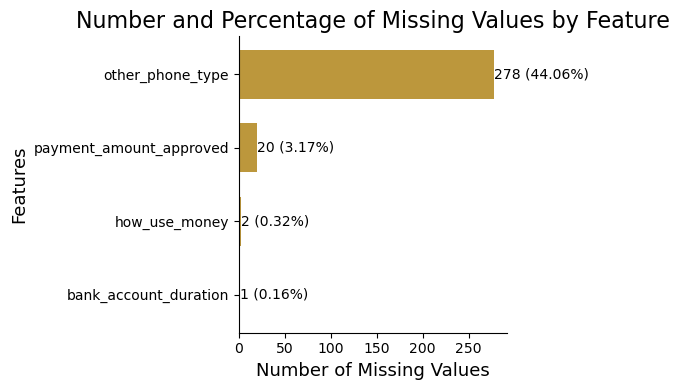

In [800]:
# Plot the data
plt.figure(figsize=(6, 4))
bars = plt.barh(variables_with_missing_values.index, variables_with_missing_values['N_missing_data'], height=0.67, color='#bc973c')

# Add percentage of missing values as labels on the bars
for bar, pct in zip(bars, variables_with_missing_values['%_missing_data']):
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height()/2, f'{xval} ({pct}%)', ha='left', va='center')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize plot
plt.ylabel('Features', fontsize=13)
plt.xlabel('Number of Missing Values', fontsize=13)
plt.title('Number and Percentage of Missing Values by Feature', fontsize=16)
plt.tight_layout()

# Save the plot
plt.savefig('missing_values.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

### Number of unique values

In [660]:
unique_values_df = variables_df['N_unique_values'].sort_values(ascending=True)

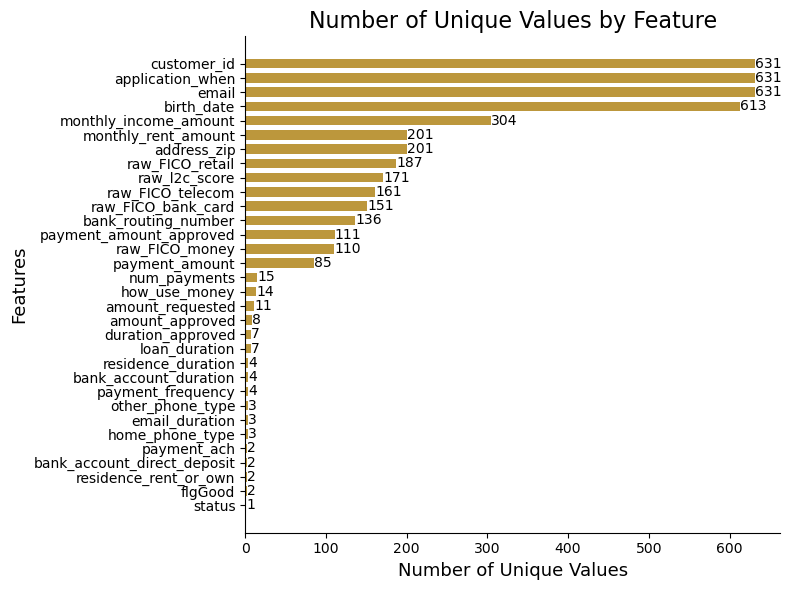

In [799]:
# Plot the data
plt.figure(figsize=(8, 6))
bars = plt.barh(unique_values_df.index, unique_values_df.values, color='#bc973c', height=0.67)

# Add percentage of missing values as labels on the bars
for bar, pct in zip(bars, unique_values_df.values):
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height()/2, f'{xval}', ha='left', va='center')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize plot
plt.ylabel('Features', fontsize=13)
plt.xlabel('Number of Unique Values', fontsize=13)
plt.title('Number of Unique Values by Feature', fontsize=16)
plt.tight_layout()

# Save the plot
plt.savefig('unique_values.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [477]:
df['address_zip'].nunique()

201

In [478]:
df['payment_ach'].value_counts()

True     630
False      1
Name: payment_ach, dtype: int64

Observations:

- Number of unique values:
  - customer_id, email and application_when have as many unique values as there are customers, which makes sense. The first two clearly won't have any influence on the target, while the third one, even though not usable as is, could be transformed in a meaningful way, for instance by extracting the year, the month, the day of week, the hour, etc.
  - birth_date has logically many (even though < number of customers) different values (601), and thus won't be of any use as is to our ML model. However, we could transform it to compute the age of the customer (at the time of credit request), which seems important to quantify the risk of the loan.
  - status has only 1 value: 'Approved'. This makes sense, as we know that the dataset contains only approved credits. Nonetheless, this 0-variance column will bring nothing to the ML model, and we can therefore drop it.
  - address_zip, which is the zip code, has too many unique values (200), and is thus not usable as is. However, what we can do is to keep only the first 3 digits, which will reduce a lot the dimensionality. Then we'll be able to perform some one-hot-encoding or frequency encoding.
  - payment_ach has 2 unique values (true and false), but only 1 out of the 618 records is false, meaning the variance is very close to 0. This won't bring any info to the model, so we can drop this column.

### Proportion of good and bad loans in the dataset

In [479]:
balance_between_classes = round(100 * df['flgGood'].value_counts() / len(df), 2)
balance_between_classes

Bad     55.47
Good    44.53
Name: flgGood, dtype: float64

In [645]:
df_target = pd.DataFrame(data={'Value Counts': df['flgGood'].value_counts(),
                               'Proportion': round(100 * df['flgGood'].value_counts() / len(df), 2)})
df_target

,Value Counts,Proportion
Bad,335,54.92
Good,275,45.08


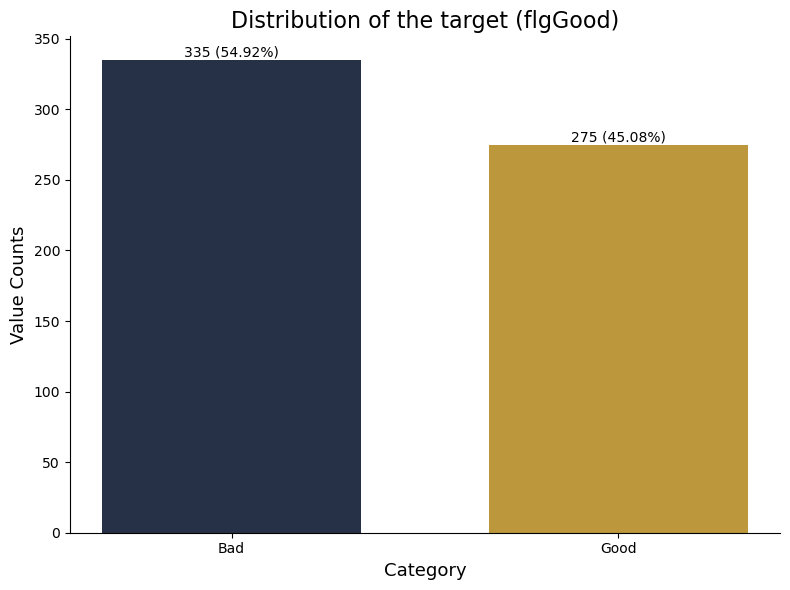

In [742]:
# Plot the data
plt.figure(figsize=(8, 6))
bars = plt.bar(df_target.index, df_target['Value Counts'], color=['#263147', '#bc973c'], width=0.67)

# Add proportion of each category as labels on the bars
for bar, pct in zip(bars, df_target['Proportion']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval} ({pct}%)', ha='center', va='bottom')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize plot
plt.xlabel('Category', fontsize=13)
plt.ylabel('Value Counts', fontsize=13)
plt.title('Distribution of the target (flgGood)', fontsize=16)
plt.xticks(rotation=0, ha='center')
plt.tight_layout()

# Save the plot
plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In the dataset, there are more Bad loans (i.e., loans that have been defaulted) than good loans (loans that were payed back). However, the difference in proportions between the 2 classes is not big enough to consider this binary classification problem as imbalanced (we generally do starting from a 70-30 ratio). Therefore, there's no immediate need for advanced resampling methods such as under-sampling or over-sampling. However, what will still be important is the choice of appropriate evaluation metrics: we can't use accuracy alone, as it will be biased towards the majority class (i.e., the chance level will be 55.47% instead of 50%). Instead, we should use metrics that will reflect performance across both classes, such as balanced accuracy, precision, recall, F1-score, AUC-ROC, AUC-PRC, etc. .

## Data cleaning and data preprocessing

### Dealing with missing data

#### other_phone_type

Let's drop the other_phone_type column.

In [485]:
df = df.drop(columns=['other_phone_type'])

#### bank_account_duration

Let's drop the rows where bank_account_duration is missing.

In [486]:
df = df.dropna(subset=['bank_account_duration'])

#### how_use_money

In [487]:
df['how_use_money'].value_counts()

Other                             320
Bills (General)                    85
Bills                              60
Bills (Auto)                       49
Bills (Medical)                    31
Car                                29
Bills (Home / Utilities)           16
Pay off loans / overdrawn acct     11
Medical                            10
Rent                                5
School                              5
Rent / Mortgage                     4
Gifts / Leisure                     3
Won't say                           1
Name: how_use_money, dtype: int64

For the missing values in 'how_use_money', instead of dropping the corresponding rows, since there's a category 'won't say', we can simply assign this category to the missing values.

In [488]:
df['how_use_money'] = df['how_use_money'].fillna("Won't say")

In [489]:
df['how_use_money'].value_counts()

Other                             320
Bills (General)                    85
Bills                              60
Bills (Auto)                       49
Bills (Medical)                    31
Car                                29
Bills (Home / Utilities)           16
Pay off loans / overdrawn acct     11
Medical                            10
Rent                                5
School                              5
Rent / Mortgage                     4
Gifts / Leisure                     3
Won't say                           2
Name: how_use_money, dtype: int64

#### payment_amount_approved

In [492]:
df = df.dropna(subset=['payment_amount_approved'])

In [493]:
# sanity check
df.isnull().sum()[df.isnull().sum()>0]

Series([], dtype: int64)

We have effectively dealt with all missing values in the dataset.

### Removing useless columns

Finally, let's drop the columns we decided to drop in the last section (EDA).

In [494]:
df = df.drop(columns=['customer_id', 'email', 'status', 'bank_routing_number', 'payment_ach'])

### Dealing with categorical variables -> will be done directly in the modeling part

Rational behind this choice: for most of the categorical variables encoding, in order to avoid data leakage, we need to fit the encoders on the train set and transform the test set using the trained encoder. However, here we haven't split the data into train/test yet, but we don't need for now. Indeed, the next 2 steps will be Feature engineering and Descriptive stats & Data Viz, for which we don't need (and it will even be clearer) to have categorical variables encoded yet.

## Feature engineering

### birth_date -> age (at the time of loan application)

In [495]:
df['application_when']

8     2010-10-26 11:22:53
20    2010-11-02 20:17:01
21    2010-11-03 08:03:44
22    2010-11-03 16:58:14
23    2010-11-04 09:23:19
              ...        
639   2011-04-16 18:45:43
640   2011-04-16 21:48:37
641   2011-04-17 11:24:27
642   2011-04-17 12:06:13
643   2011-04-17 21:15:49
Name: application_when, Length: 610, dtype: datetime64[ns]

In [496]:
df['birth_date']

8     1961-04-20
20    1977-12-07
21    1980-03-31
22    1981-03-25
23    1980-02-19
         ...    
639   1981-10-15
640   1946-03-06
641   1976-05-25
642   1960-06-09
643   1957-05-06
Name: birth_date, Length: 610, dtype: datetime64[ns]

In [497]:
# Calculate the difference in years, which corresponds to the age of the customer at the time of the application
df['age'] = ((df['application_when'] - df['birth_date']) / pd.Timedelta(days=365.25)).round().astype(int)

# Drop the column birth_date that is no longer needed
df = df.drop(columns=['birth_date'])

### application_when -> year, month, day of week

In [499]:
df['application_when']

8     2010-10-26 11:22:53
20    2010-11-02 20:17:01
21    2010-11-03 08:03:44
22    2010-11-03 16:58:14
23    2010-11-04 09:23:19
              ...        
639   2011-04-16 18:45:43
640   2011-04-16 21:48:37
641   2011-04-17 11:24:27
642   2011-04-17 12:06:13
643   2011-04-17 21:15:49
Name: application_when, Length: 610, dtype: datetime64[ns]

In [500]:
# Create three new features from the feature application_when: the year, the month and the day of week
df['application_year'] = df['application_when'].dt.year
df['application_month'] = df['application_when'].dt.month
df['application_day_of_week'] = df['application_when'].dt.day_of_week

# Drop the original feature that's no longer needed
df = df.drop(columns=['application_when'])

Potentially important remark:
- The month and day start at 1 (respectively 1 to 12 and 1 to 31), while the day of week starts at 0 (0 to 6).
- We know that the data cover 6 months of loan applications, but those 6 months are not consecutive. We have applications from January to April (included), and then nothing from may to september (why?), and then new applications from october to december (included).

### address zip -> first 3 digits

In [501]:
# Replace the full zip code by its first 3 digits
df['truncated_zip'] = df['address_zip'].astype(str).map(lambda x: x[:3])

# Drop the original column
df = df.drop(columns=['address_zip'])

In [502]:
df['truncated_zip']

8      841
20     840
21     844
22     841
23     841
      ... 
639    840
640    841
641    840
642    838
643    833
Name: truncated_zip, Length: 610, dtype: object

### Computing some potentially useful ratios

#### Debt-to-income ratio (DTI)

In [503]:
df['DTI'] = round((df['monthly_rent_amount'] + df['payment_amount']) / df['monthly_income_amount'], 2)

#### Approved debt-to-income ratio (DTI)

In [504]:
df['approved_DTI'] = round((df['monthly_rent_amount'] + df['payment_amount_approved']) / df['monthly_income_amount'], 2)

#### Approved-to-requested ratios

In [505]:
df['approved_to_requested_amount'] = round(df['amount_approved'] / df['amount_requested'], 2)
df['payment_amount_approved_to_payment_approved'] = round(df['payment_amount_approved'] / df['payment_amount'], 2)

#### Loan-duration-to-approved-duration ratio

In [506]:
df['approved_duration_to_loan_duration'] = round(df['duration_approved'] / df['loan_duration'] , 2)

### Create an average FICO score

In [509]:
df['avg_FICO_score'] = ((df['raw_FICO_money'] + df['raw_FICO_retail'] + df['raw_FICO_telecom'] + df['raw_FICO_bank_card'])/4).astype(int)

### Dealing with how_use_money

In [510]:
df['how_use_money'].value_counts()

Other                             300
Bills (General)                    85
Bills                              60
Bills (Auto)                       49
Bills (Medical)                    31
Car                                29
Bills (Home / Utilities)           16
Pay off loans / overdrawn acct     11
Medical                            10
Rent                                5
School                              5
Rent / Mortgage                     4
Gifts / Leisure                     3
Won't say                           2
Name: how_use_money, dtype: int64

- From the bivariate plot showing the relationship between the target and this variable, it seems the latter has an significant influence on the former. However, by looking at the distribution of the data across the different categories of this variable, we can see a big imbalance. For instance, 'Rent', 'School', 'Rent/Mortgage', 'Gifts/Leisure' and 'Won't say' all have less than 10 records, so it will be hard for the model to learn from those. We can either drop those, or try to include them in other categories with more examples, in a way that makes the most sense. For instance, 'Rent' and 'Rent/mortage' can be merged together. 'Won't say', which has only 1 record, can for instance be merged with 'Others'
- Plus, there are many subcategories of bills, that we could regroup together.
- 'Medical' can also be merged with 'Bills (Medical)', which itself gets merged into 'Bills'
- 'Auto' can also be merged with 'Bills (Auto)', which itself gets merged into 'Bills'
- Other is the most represented category by far, but we don't which one it is. So maybe an idea would be (once we have created the new categories) to create a new binary column indicating whether how_use_money is equal to 'Other' or not.

In [511]:
new_categories_how_use_money = {'Bills': 'bills_and_utilities',
                                'Bills (General)': 'bills_and_utilities',
                                'Bills (Home / Utilities)': 'bills_and_utilities',
                                'Bills (Auto)': 'bills_and_utilities',
                                'Bills (Medical)': 'bills_and_utilities',

                                'Car':'personal_and_family_expenses',
                                'Medical': 'personal_and_family_expenses',
                                'School': 'personal_and_family_expenses',
                                'Gifts / Leisure': 'personal_and_family_expenses',

                                'Pay off loans / overdrawn acct': 'debt',
                                'Rent': 'debt',
                                'Rent / Mortgage': 'debt',

                                'Other': 'other',
                                "Won't say": 'other'
                                }

df['how_use_money'] = df['how_use_money'].map(new_categories_how_use_money)

In [512]:
df['how_use_money'].value_counts()

other                           302
bills_and_utilities             241
personal_and_family_expenses     47
debt                             20
Name: how_use_money, dtype: int64

In [514]:
# df['how_use_money_other'] = (df['how_use_money'] == 'other')

## Descriptive statistics and Data Viz

### Train test split

CAREFUL: in order to avoid data leakage, we should compute all following data viz ONLY on the training set, and not on the entire dataset. This is why we're doing the train/test split now and not in the modeling part

In [ ]:
target_variable = 'flgGood'

In [941]:
# Separate features and target variable in the dataset
X = df.drop(columns=[target_variable])
y = df[target_variable]

# Encode the target using Label Encoder
label_encoder = LabelEncoder()  # bad = 0, good = 1
y = label_encoder.fit_transform(y)

# Separate train and test datasets
# Use stratify=y to preserve the same proportion of the target in both y_train and y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [942]:
# Check balance between Good and Bad is approximately the same in y_train and y_test
# Since we used stratify=y, the proportion should by design be the same across y, y_train and y_test
print(f'The proportion of good loans in y is {round(y.mean(), 2)}')
print(f'The proportion of good loans in y_train is {round(y_train.mean(), 2)}')
print(f'The proportion of good loans in y_test is {round(y_test.mean(), 2)}')

The proportion of good loans in y is 0.45
The proportion of good loans in y_train is 0.45
The proportion of good loans in y_test is 0.45


In [520]:
label_encoder.classes_

array(['Bad', 'Good'], dtype=object)

In [522]:
df['flgGood']

8       Bad
20     Good
21      Bad
22     Good
23      Bad
       ... 
639     Bad
640    Good
641    Good
642     Bad
643    Good
Name: flgGood, Length: 610, dtype: object

In [521]:
y

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,

### [Archive] Univariate plots

#### Categorical variables

In [523]:
# # Define the function plot_categorical_barplot
# def plot_categorical_barplot(column_name, ax=None, horizontal_labels=True):
#     """
#     Plots a univariate barplot of frequencies for a categorical variable with proportions inside each bar.

#     Parameters:
#     column_name (str): The name of the categorical variable column to plot.
#     ax (matplotlib.axes.Axes): Axis to plot on. If None, creates a new plot.
#     """
#     # Calculate frequencies of the categorical variable
#     category_counts = X_train[column_name].value_counts()

#     # Calculate proportions
#     category_proportions = category_counts / category_counts.sum()

#     # Plotting the bar plot
#     if ax is None:
#         fig, ax = plt.subplots(figsize=(10, 6))
#     else:
#         fig = ax.get_figure()

#     # Create the bar plot
#     bars = category_counts.plot(kind='bar', ax=ax)
#     if horizontal_labels:
#         ax.set_xticklabels(category_counts.index, rotation=0, ha='center')

#     # Set title and axis names
#     #ax.set_title(f'Frequency of {column_name}', fontsize=16)
#     ax.set_xlabel(column_name, fontsize=14)
#     #ax.set_ylabel('Frequency', fontsize=14)

#     # Add legend
#     #ax.legend(['Frequency'], loc='upper right')

#     # Add proportions on top of each bar
#     for i, (count, proportion) in enumerate(zip(category_counts, category_proportions)):
#         ax.text(i, count + 0.05, f'{proportion:.0%}', ha='center', fontsize=10)

#     # Remove top and right lines of the box
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

#     # Adjust layout if a new figure was created
#     if ax is None:
#         plt.tight_layout()
#         plt.show()

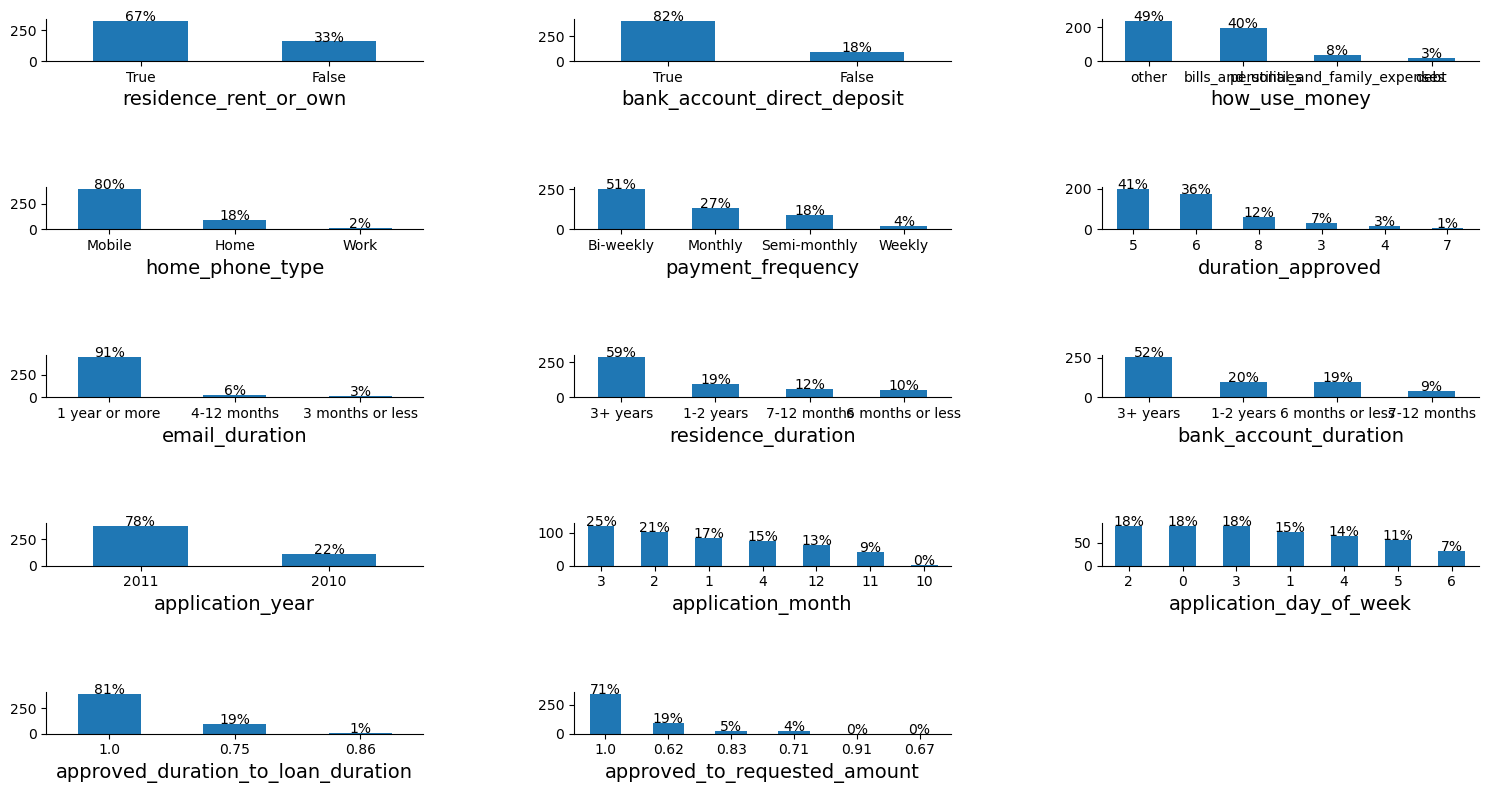

In [765]:
# categorical_features = ['residence_rent_or_own', 'bank_account_direct_deposit',
#                         'home_phone_type', 'payment_frequency','duration_approved',
#                         'email_duration', 'residence_duration', 'bank_account_duration', 'application_year',
#                         'application_month', 'application_day_of_week', 'approved_duration_to_loan_duration', 'approved_to_requested_amount']

# # Note: we consider the durations above as categorical bc they have very few different values

# # Calculate the number of rows and columns for the subplots
# n_plots = len(categorical_features)
# n_cols = 3
# n_rows = math.ceil(n_plots / n_cols)

# fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 8))

# # Flatten the axs array for easy iteration
# axs = axs.flatten()

# # Plot each categorical variable in a separate subplot
# for ax, col_name in zip(axs, categorical_features):
#     plot_categorical_barplot(col_name, ax)

# # Hide any unused subplots
# for ax in axs[n_plots:]:
#     ax.set_visible(False)

# plt.tight_layout()
# plt.subplots_adjust(hspace=3, wspace=0.4)
# plt.show()

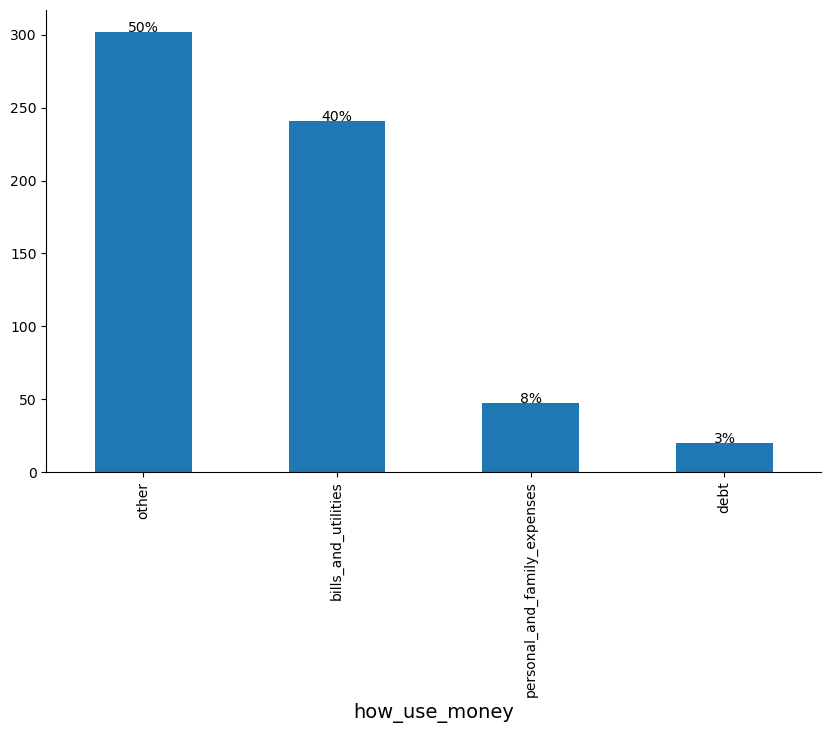

In [261]:
# Doing the plot for the variable 'how_use_money'
plot_categorical_barplot('how_use_money', ax=None, horizontal_labels=False)

#### Numerical variables

In [262]:
# # Function to plot histograms for numerical variables
# def plot_numerical_histogram(column_name, ax=None):
#     """
#     Plots a histogram of a numerical variable.

#     Parameters:
#     column_name (str): The name of the numerical variable column to plot.
#     ax (matplotlib.axes.Axes): Axis to plot on. If None, creates a new plot.
#     """
#     # Plotting the histogram
#     if ax is None:
#         fig, ax = plt.subplots(figsize=(10, 6))
#     else:
#         fig = ax.get_figure()

#     # Create the histogram
#     ax.hist(df[column_name], bins=20)

#     # Set title and axis labels
#     #ax.set_title(f'Distribution of {column_name}', fontsize=16)
#     ax.set_xlabel(column_name, fontsize=14)
#     #ax.set_ylabel('Frequency', fontsize=14)

#     # Remove top and right lines of the box
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

#     # Adjust layout if a new figure was created
#     if ax is None:
#         plt.tight_layout()
#         plt.show()

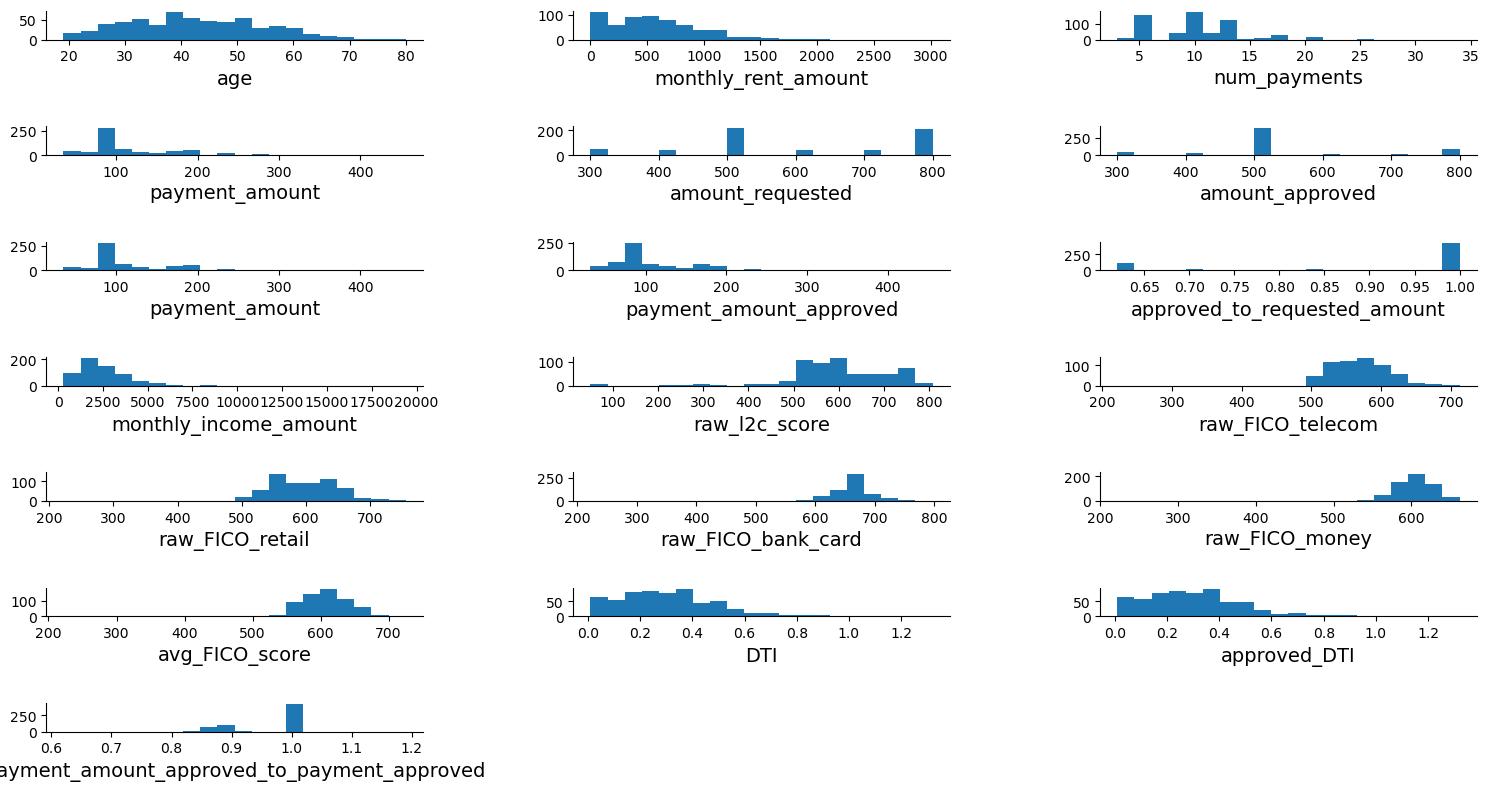

In [263]:
# numerical_features = ['age', 'monthly_rent_amount', 'num_payments', 'payment_amount', 'amount_requested', 'amount_approved', 'payment_amount',
#                     'payment_amount_approved', 'approved_to_requested_amount', 'monthly_income_amount', 'raw_l2c_score', 'raw_FICO_telecom',
#                      'raw_FICO_retail', 'raw_FICO_bank_card', 'raw_FICO_money', 'avg_FICO_score', 'DTI', 'approved_DTI',
#                      'payment_amount_approved_to_payment_approved']

# # Calculate the number of rows and columns for the subplots
# n_plots = len(numerical_features)
# n_cols = 3
# n_rows = math.ceil(n_plots / n_cols)

# fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 8))

# # Flatten the axs array for easy iteration
# axs = axs.flatten()

# # Plot each numerical variable in a separate subplot
# for ax, col_name in zip(axs, numerical_features):
#     plot_numerical_histogram(col_name, ax)

# # Hide any unused subplots
# for ax in axs[n_plots:]:
#     ax.set_visible(False)

# plt.tight_layout()
# plt.subplots_adjust(hspace=3, wspace=0.4)
# plt.show()

### Bivariate plots between the target and each individual feature

#### Categorical features

In [534]:
target_variable = 'flgGood'
categorical_features = ['residence_rent_or_own', 'bank_account_direct_deposit',
                        'home_phone_type', 'payment_frequency','duration_approved',
                        'email_duration', 'residence_duration', 'bank_account_duration', 'application_year',
                        'application_month', 'application_day_of_week', 'approved_duration_to_loan_duration', 'approved_to_requested_amount']

In [540]:
# We need to recreate df_train as for the bivariate plots and the chi-square tests, we'll need both X_train and y_train

# Convert y_train to a DataFrame
y_train_df = pd.DataFrame(y_train, columns=['flgGood'])

# Concatenate X_train and y_train_df along columns
df_train = pd.concat([X_train.reset_index(drop=True), y_train_df], axis=1)
df_train['flgGood'] = df_train['flgGood'].map(lambda x: 'Bad' if x==0 else 'Good')

In [762]:
def plot_categorical_stacked_barplot(column_name, ax=None, horizontal_labels=True, how_use_money=True):
    """
    Plots a stacked barplot of proportions for a categorical variable with two categories (e.g., binary target).

    Parameters:
    column_name (str): The name of the categorical variable column to plot.
    ax (matplotlib.axes.Axes): Axis to plot on. If None, creates a new plot.
    """
    # Calculate proportions using groupby and value_counts
    proportions_df = df_train.groupby(column_name)[target_variable].value_counts(normalize=True).unstack(fill_value=0)

    # Invert the order of stacking (put 'Bad' on top of 'Good')
    proportions_df = proportions_df[['Good', 'Bad']]

    # Plotting the stacked bar plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.get_figure()

    # Define custom colors
    custom_colors = ['#bc973c', '#263147']  # 'Good' first, 'Bad' second

    # Plot each category as a stacked bar with custom colors
    bars = proportions_df.plot(kind='bar', stacked=True, ax=ax, color=custom_colors, width=0.67)

    # Add proportions within each bar segment
    for bar in bars.containers:
        for rect in bar:
            height = rect.get_height()
            if height > 0:  # Only add text for non-zero segments
                ax.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2,
                        f'{height:.0%}', ha='center', va='center', fontsize=9, color='white', fontweight='bold')

    # Set labels and title
    ax.set_xlabel(column_name, fontsize=12)

    if how_use_money:
        ax.set_ylabel('Proportion', fontsize=13)
        ax.set_title(f' {target_variable} vs how_use_money', fontsize=16)

    # Remove top and right lines of the box
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set x-axis tick labels horizontally
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')

    # Adjust layout if a new figure was created
    if ax is None:
        plt.tight_layout()
        plt.show()

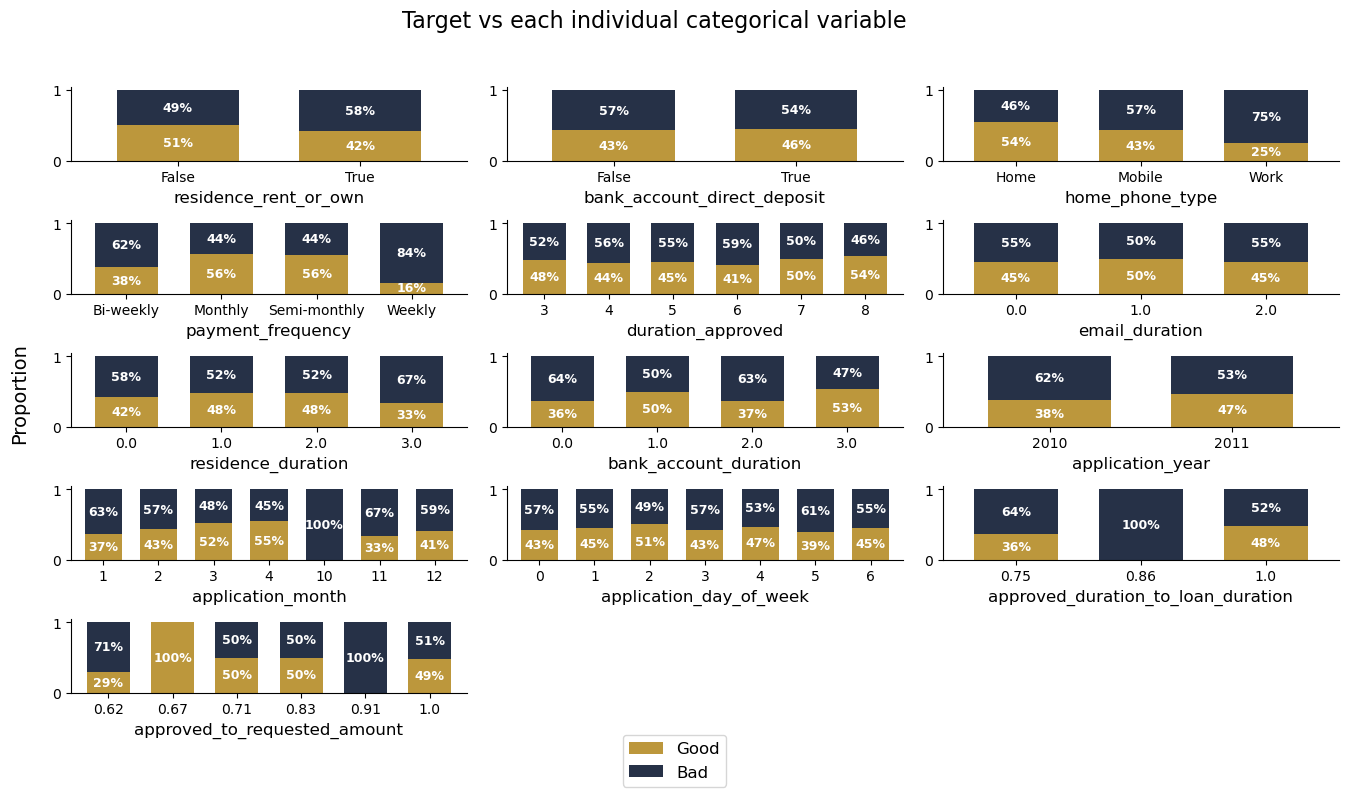

In [763]:
# Calculate the number of rows and columns for the subplots
n_plots = len(categorical_features)
n_cols = 3
n_rows = math.ceil(n_plots / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 8))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot each categorical variable in a separate subplot
for ax, col_name in zip(axs, categorical_features):
    plot_categorical_stacked_barplot(col_name, ax, how_use_money=False)
    ax.legend().remove()  # Remove individual legends

# Hide any unused subplots
for ax in axs[n_plots:]:
    ax.set_visible(False)

# Add global y-label
fig.text(0.04, 0.5, 'Proportion', va='center', rotation='vertical', fontsize=14)

# Add global title
fig.suptitle('Target vs each individual categorical variable', fontsize=16)

# Add a single legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize=12)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.subplots_adjust(hspace=0.8, wspace=0.1)

# Save the plot
plt.savefig('target_vs_cat_variables.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

Example of interpretations from the stacked barplots:
- Payment frequency: The type of repayment associated to the highest (resp. lowest) frequency of bad loans is weekly (resp. monthly & semi-monthly).
- Application year: The proportion of bad loans has decreased from 64% to 54% from 2010 to 2011.

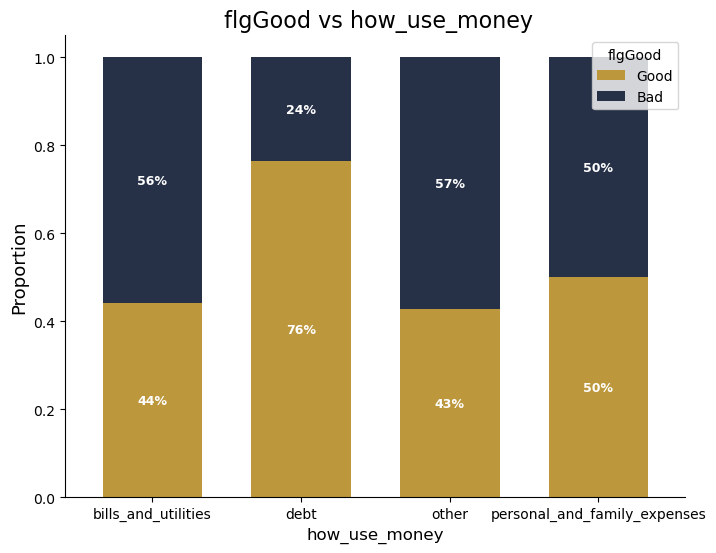

In [767]:
plot_categorical_stacked_barplot('how_use_money', ax=None, horizontal_labels=True)
# Save the plot
plt.savefig('target_vs_how_use_money.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

Observations:
- Some categorical variables that seem to have an significant (careful, the statistical significance can only be determined using a test) influence on the target are: residence_rent_or_own, bank_account_duration, payment_frequency, application_year, application_month and how_use_money.
  - In particular, the way borrowers intend to use their money seems to have a huge influence on the target. For instance, only 24% of borrowers who used the money for debt repayment defaulted, while this proportion was up to 50% for personal and family expenses.
- On the contrary, some categorical variables that don't seem to have an significant influence on the target are: email_duration, application_day_of_week.

#### Numerical features

In [769]:
numerical_features = ['age', 'monthly_rent_amount', 'num_payments',
                      'amount_approved', 'payment_amount_approved',
                      'monthly_income_amount', 'raw_l2c_score',
                      'avg_FICO_score',
                      'approved_DTI']

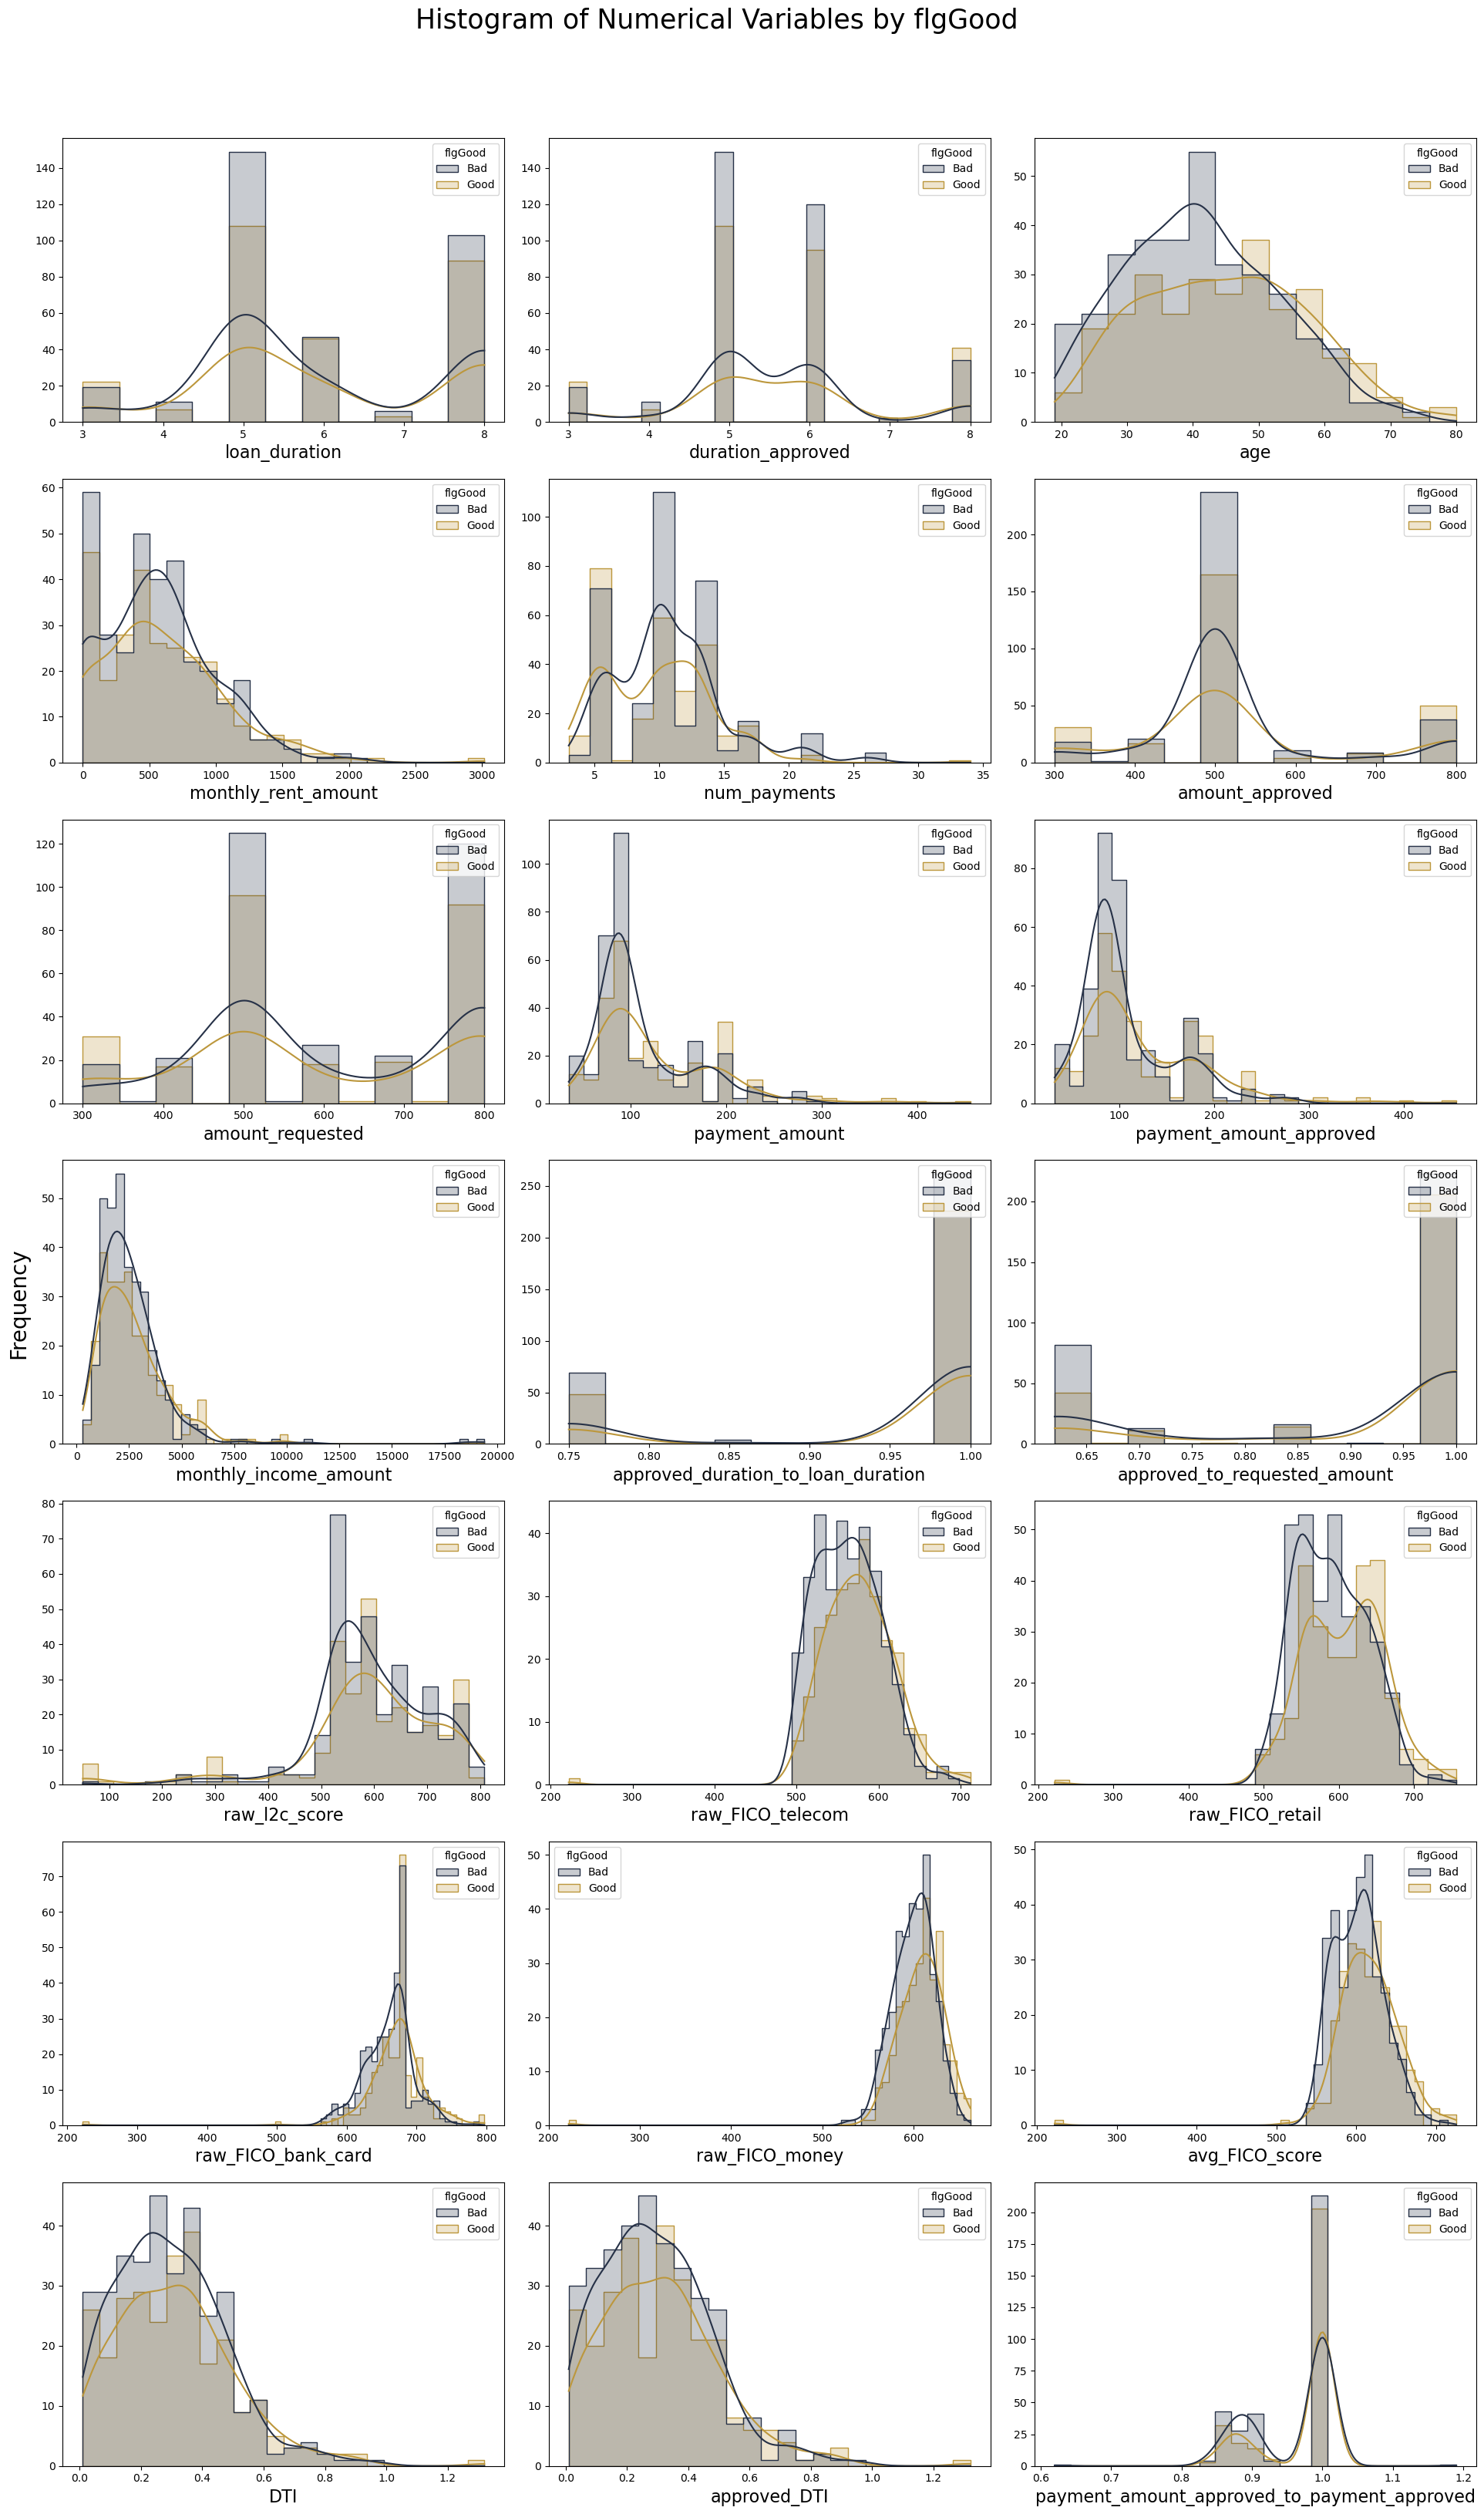

In [790]:
# Calculate the number of rows and columns for the subplots
n_features = len(numerical_features)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

# Plot each numerical variable in a separate subplot
for i, feature in enumerate(numerical_features):
    row = i // n_cols
    col = i % n_cols
    sns.histplot(data=df, x=feature, hue='flgGood', kde=True, element="step", ax=axs[row, col], palette={'Bad': '#263147', 'Good': '#bc973c'})
    axs[row, col].set_xlabel(feature, fontsize=16)  # Increase x-label size
    axs[row, col].set_ylabel('')  # Remove y-label
    axs[row, col].set_title('')  # Remove individual titles

# Remove any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axs.flatten()[j])

# Add global y-label
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=20)

# Add global title
fig.suptitle('Histogram of Numerical Variables by flgGood', fontsize=25)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.savefig('Histograms.png', dpi=300, bbox_inches='tight', pad_inches=0.1)


Observation:
- Lot of overlap: not a great sign because it means each individual numerical feature is not very useful to discriminate between a good and a bad loan. Maybe they will be more useful once combined together in a model.

### Correlations matrices

In [796]:
numerical_features = ['loan_duration', 'duration_approved', 'age', 'monthly_rent_amount', 'num_payments',
                      'amount_approved', 'amount_requested','payment_amount', 'payment_amount_approved',
                      'monthly_income_amount', 'approved_duration_to_loan_duration', 'approved_to_requested_amount', 'raw_l2c_score',
                      'raw_FICO_telecom', 'raw_FICO_retail', 'raw_FICO_bank_card', 'raw_FICO_money', 'avg_FICO_score',
                      'DTI', 'approved_DTI']

nominal_features = ['residence_rent_or_own', 'bank_account_direct_deposit', 'application_year',
                    'payment_frequency', 'home_phone_type', 'application_month',
                    'application_day_of_week', 'how_use_money', 'truncated_zip']

ordinal_features = ['email_duration', 'residence_duration', 'bank_account_duration']

#### Numerical Features - Pearson Correlation Matrix

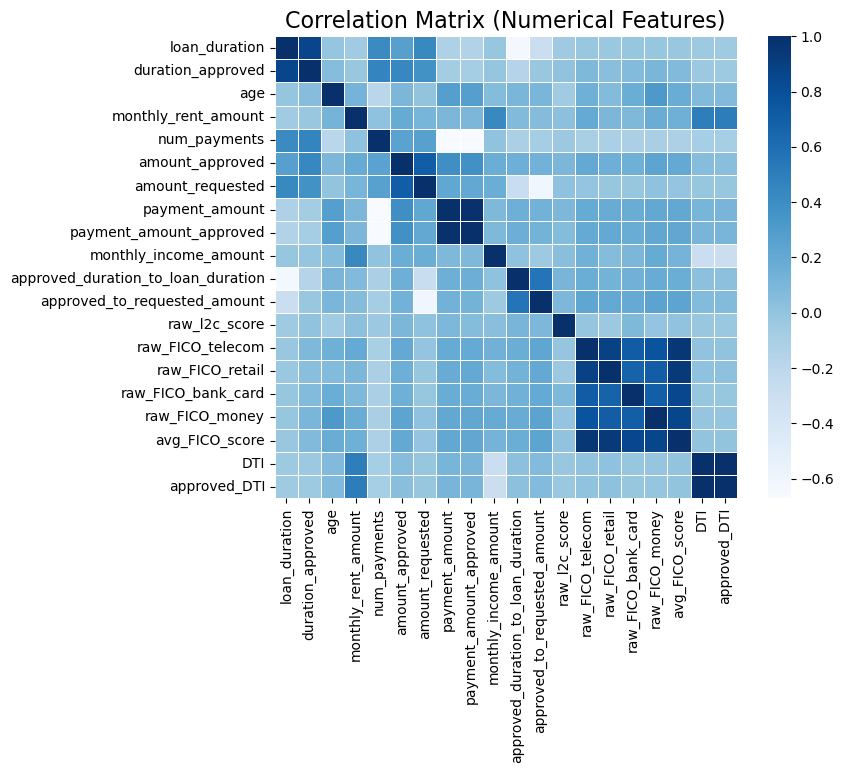

In [797]:
# Compute Pearson correlation matrix
pearson_corr = X_train[numerical_features].corr()

# Plot the Pearson correlation matrix with the upper triangle masked
plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr, annot=False, cmap='Blues', fmt='.2f', cbar=True,
            square=True, linewidths=0.5)

# Customize plot
plt.title('Correlation Matrix (Numerical Features)', fontsize=16)
plt.savefig('Corr_matrix.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

Observations:
- Duration approved (final duration of the loan) is, as expected, highly correlated with loan_duration (duration requested by the borrower). Since the most accurate information would be the former, let's keep this one and drop the latter.
- Same thing for amount_requested vs amount_approved, payment_amount vs payment_amount_approved, and DTI vs approved_DTI.
- As expected, all the FICO score are highly correlated (2 by 2). We can try to keep only the average of those and drop all individual scores, and see if it improves the predictive power of the model.
- Payment_amount_approved is highly correlated with num_payment, which makes sense because both are directly related. Basically, out of the 3 features amount_approved, num_payments and Payment_amount_approved, if we have 2 out of 3, we can easily deduce the 3rd one. So we should not keep all 3. Let's try to drop num_payments for now.
- approved_DTI is highly correlated with monthly_rent_amount, which again makes sense because those 2 variables are directly related through a mathematical formula. Let's try to only keep the first one and drop the second.
- duration_approved and amount_approved are logically highly correlated, so let's try to only keep one of them, for instance 

#### Ordinal Features - Spearman’s Rank Correlation Matrix

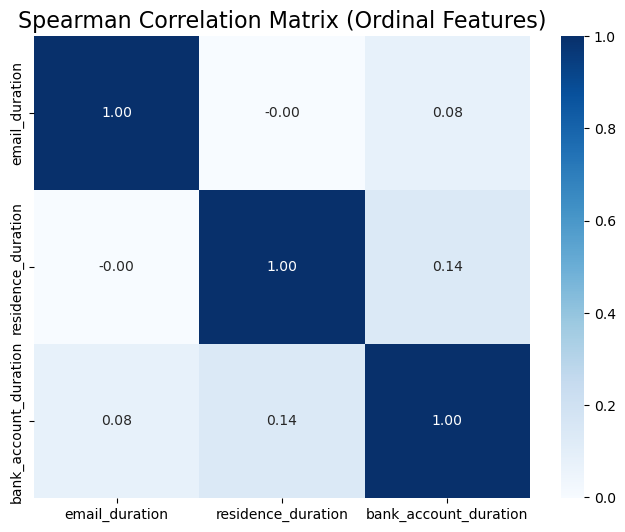

In [793]:
# Compute Spearman correlation matrix for ordinal features
ordinal_corr, _ = spearmanr(X_train[ordinal_features])

# Convert the correlation matrix to a DataFrame for easier plotting
ordinal_corr_df = pd.DataFrame(ordinal_corr, index=ordinal_features, columns=ordinal_features)

# Plot Spearman Correlation Matrix for Ordinal Features
plt.figure(figsize=(8, 6))
sns.heatmap(ordinal_corr_df, annot=True, cmap='Blues', fmt='.2f', cbar=True)
plt.title('Spearman Correlation Matrix (Ordinal Features)', fontsize=16)
plt.savefig('Spearman_matrix.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

Observations:
- There's no obvious pairwise correlation between any pair of ordinal features.

#### Nominal Features - Cramér’s V Matrix

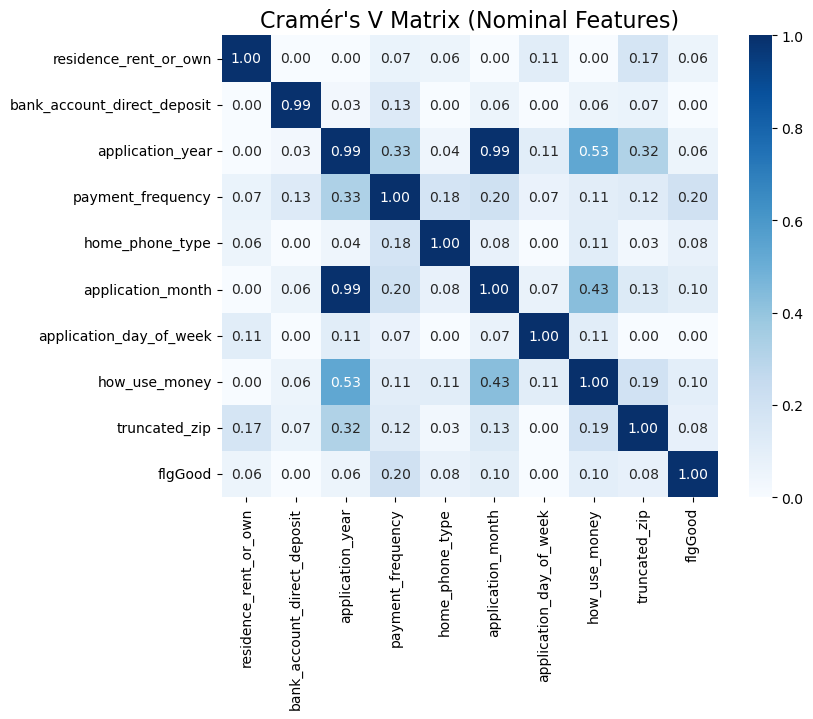

In [794]:
# Function to compute Cramer's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Compute the Cramér's V matrix for nominal features
def cramers_v_matrix(df, columns):
    n = len(columns)
    cramers_v_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            confusion_matrix = pd.crosstab(df[columns[i]], df[columns[j]])
            cramers_v_matrix[i, j] = cramers_v(confusion_matrix)
    return pd.DataFrame(cramers_v_matrix, index=columns, columns=columns)

# Assuming X_train is your training data and nominal_features is the list of nominal feature names
cramers_v_corr = cramers_v_matrix(df_train, nominal_features + ['flgGood'])

# Plot Cramér's V Matrix for Nominal Features
plt.figure(figsize=(8, 6))
sns.heatmap(cramers_v_corr, annot=True, cmap='Blues', fmt='.2f', cbar=True)
plt.title("Cramér's V Matrix (Nominal Features)", fontsize=16)
plt.savefig('Cramer_matrix.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

Observations:
- There appears to be a strong relationship between application_year and application_month. As we can see below, this can be explained by the fact that loans in X_train are from October 2010 to April 2011, and thus, we know that if a loan is in 2011, then automatically its month is between October and December, while if its in 2011, its month is between January and April. Since we only have data for those 2 years, it may not be highly useful to keep the application_year feature, especially if we're trying to predict loan outcomes in future years. However, the application_month, which is cyclical, can be useful. Therefore, let's try to drop the year and keep the month.

In [ ]:
X_train.loc[X_train['application_year'] == 2010, 'application_month'].value_counts()

12    63
11    42
10     1
Name: application_month, dtype: int64

In [ ]:
X_train.loc[X_train['application_year'] == 2011, 'application_month'].value_counts()

3    122
2    102
1     83
4     75
Name: application_month, dtype: int64

#### Chi-square tests of independence between the target and each categorical feature

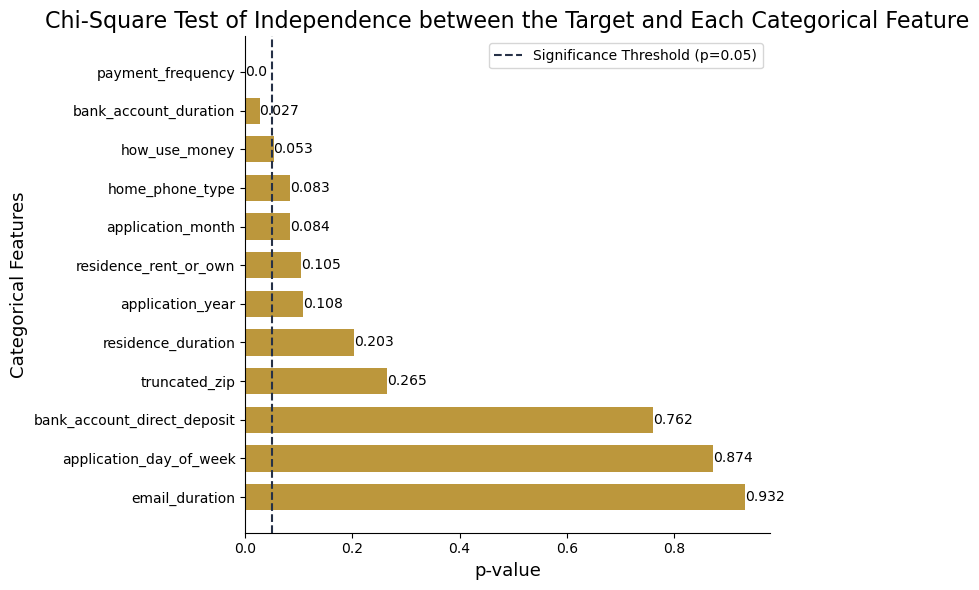

In [795]:
# Convert ordinal features to numerical for Chi-Square Test
df_train[ordinal_features] = OrdinalEncoder().fit_transform(df_train[ordinal_features])

def chi2_test_between_groups(df, feature1, feature2):
    crosstab = pd.crosstab(df[feature1], df[feature2])
    chi2_stat, p_val, _, _ = chi2_contingency(crosstab)
    return chi2_stat, p_val

# Loop through categorical features and compute Chi-Square Test with the (categorical) target
cat_features = nominal_features + ordinal_features
chi2_results = []

for cat_feature in cat_features:
    chi2_stat, p_val = chi2_test_between_groups(df_train, cat_feature, target_variable)
    chi2_results.append((cat_feature, p_val))

# Convert results to a DataFrame for easier plotting
chi2_results_df = pd.DataFrame(chi2_results, columns=['Feature', 'p-value']).sort_values(by='p-value', ascending=False)

# Plotting
plt.figure(figsize=(8, 6))

# Horizontal bar plot
bars = plt.barh(chi2_results_df['Feature'], chi2_results_df['p-value'], color='#bc973c', height=0.68)

# Add a vertical line for the significance threshold at p=0.05
plt.axvline(x=0.05, color='#263147', linestyle='--', label='Significance Threshold (p=0.05)')

# Add p-values as labels on the bars
for bar, p_val in zip(bars, chi2_results_df['p-value']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{round(p_val, 3)}', va='center', ha='left')

# Customize plot
plt.xlabel('p-value', fontsize=13)
plt.ylabel('Categorical Features', fontsize=13)
plt.title('Chi-Square Test of Independence between the Target and Each Categorical Feature', fontsize=16)
plt.legend(loc='upper right')
plt.tight_layout()

# Remove top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show plot
plt.savefig('p_values.png', dpi=300, bbox_inches='tight', pad_inches=0.1)


Interpretation: cf slides

## Modeling

### Preprocessing

In [808]:
# Define the numerical features
numerical_features = ['duration_approved', 'age', 'amount_approved', 'payment_amount_approved', 'monthly_rent_amount',
                        'num_payments', 'monthly_income_amount', 'approved_to_requested_amount', 'raw_l2c_score',
                        'avg_FICO_score', 'approved_DTI', 'payment_amount_approved_to_payment_approved']

# Define the ordinal features and their respective ordered categories. Those will be preprocessed using ordinal encoding
ordinal_features = ['residence_duration', 'bank_account_duration']

ordered_categories = [['6 months or less', '7-12 months', '1-2 years', '3+ years'],
                      ['6 months or less', '7-12 months', '1-2 years', '3+ years']]

# Define the nominal features. Those will be one-hot-encoded
nominal_features = ['residence_rent_or_own', 'payment_frequency', 'application_month', 'how_use_money', 'truncated_zip']

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('ord_cat', OrdinalEncoder(categories=ordered_categories), ordinal_features),  # Ordinal encode ordinal categorical features
        ('nom_cat', OneHotEncoder(handle_unknown='ignore'), nominal_features),  # One-hot encode nominal categorical features
        ('num', StandardScaler(), numerical_features)  # scale the numerical features for distance based algorithms such as logistic regression
    ])

### Models and their grid of hyperparameters

In [809]:
models = [
    ('Dummy Classifier', DummyClassifier(), {
        'clf__strategy': ['most_frequent', 'uniform']
    }),
    ('Logistic Regression', LogisticRegression(max_iter=10000), {
        'clf__penalty': ['l1', 'l2', 'elasticnet'],
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'clf__solver': ['liblinear', 'saga'],
        'clf__l1_ratio': np.linspace(0, 1, 5)  # Only relevant if penalty is 'elasticnet'
    }),
    ('Decision Tree', DecisionTreeClassifier(), {
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 5],
        'clf__max_features': [None, 'sqrt', 'log2'],
        'clf__criterion': ['gini', 'entropy', 'log_loss']
    }),
    ('Random Forest', RandomForestClassifier(), {
        'clf__n_estimators': [100, 200, 500],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 5],
        'clf__max_features': ['sqrt', 'log2'],
        'clf__bootstrap': [True, False]
    }),
    ('XGBoost', XGBClassifier(), {
        'clf__n_estimators': [100, 200, 500],
        'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'clf__max_depth': [3, 6, 10],
        'clf__min_child_weight': [1, 3, 5],
        'clf__gamma': [0, 0.1, 0.2],
        'clf__subsample': [0.7, 0.8, 1.0],
        'clf__colsample_bytree': [0.7, 0.8, 1.0]
    }),
    ('LightGBM', LGBMClassifier(n_jobs=-1), {
        'clf__n_estimators': [100, 200, 500],
        'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'clf__num_leaves': [31, 63, 127],
        'clf__max_depth': [-1, 10, 20, 30],
        'clf__min_child_samples': [20, 50, 100],
        'clf__subsample': [0.5, 0.7, 0.8, 1.0],
        'clf__colsample_bytree': [0.5, 0.7, 0.8, 1.0]
    }),
    ('CatBoost', CatBoostClassifier(), {
        'clf__iterations': [100, 200, 500],
        'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
        'clf__depth': [4, 6, 8, 10],
        'clf__l2_leaf_reg': [1, 3, 5, 7],
        'clf__border_count': [32, 64, 128],
        'clf__bagging_temperature': [0, 0.1, 0.2, 0.3]
    })
]

### Metrics

In [810]:
# Metrics to evaluate the models above
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'precision': make_scorer(precision_score, average='binary'),
    'recall': make_scorer(recall_score, average='binary'),
    'f1': make_scorer(f1_score, average='binary'),
    'roc_auc': make_scorer(roc_auc_score),
    'average_precision': make_scorer(average_precision_score)
}

### Cross-validation strategy

In [811]:
# Cross-validation configuration - stratified in order to have same proportions of the target in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Randomized Search CV

In [814]:
def perform_random_search(model_name, model, param_grid, cv, scoring):
    # Define the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('clf', model)])

    # Perform RandomizedSearchCV to find the best hyperparameters
    random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, scoring='accuracy', cv=cv, n_jobs=-1, n_iter=100, random_state=42)
    random_search.fit(X_train, y_train)

    # Get the best estimator
    best_model = random_search.best_estimator_

    # Store the best hyperparameters
    best_params = random_search.best_params_

    # Perform cross-validation with the best estimator (wrt to accuracy) in order to get its other metrics using cv
    scores = cross_validate(best_model, X_train, y_train, scoring=scoring, cv=cv, return_train_score=False)

    # Store the mean of each metric in a DataFrame
    model_results = pd.DataFrame([{
        'Model': model_name,
        'Best Params': str(best_params),
        'Accuracy': round(np.mean(scores['test_accuracy']), 3),
        'Balanced Accuracy': round(np.mean(scores['test_balanced_accuracy']), 3),
        'Precision': round(np.mean(scores['test_precision']), 3),
        'Recall': round(np.mean(scores['test_recall']), 3),
        'F1 Score': round(np.mean(scores['test_f1']), 3),
        'AUC-ROC': round(np.mean(scores['test_roc_auc']), 3),
        'AU-PRC': round(np.mean(scores['test_average_precision']), 3)
    }])

    # Return the results
    return model_results

In [ ]:
# List to store the results DataFrames
results_list = []

# Evaluate each model
for model_name, model, param_grid in models:
    model_results = perform_random_search(model_name, model, param_grid, cv, scoring)
    results_list.append(model_results)

# Concatenate all the individual DataFrames into one
results_random_search_df = pd.concat(results_list, ignore_index=True)

In [840]:
# Display the results
results_random_search_df

,Model,Best Params,Accuracy,Balanced Accuracy,Precision,Recall,F1 Score,AUC-ROC,AU-PRC
0,Dummy Classifier,{'clf__strategy': 'most_frequent'},0.549,0.500,0.000,0.000,0.000,0.500,0.451
1,Logistic Regression,"{'clf__solver': 'saga', 'clf__penalty': 'l2', ...",0.629,0.609,0.639,0.400,0.487,0.609,0.532
2,Decision Tree,"{'clf__min_samples_split': 2, 'clf__min_sample...",0.613,0.605,0.575,0.527,0.549,0.605,0.519
3,Random Forest,"{'clf__n_estimators': 200, 'clf__min_samples_s...",0.629,0.613,0.628,0.450,0.521,0.613,0.531
4,XGBoost,"{'clf__subsample': 0.7, 'clf__n_estimators': 2...",0.621,0.604,0.615,0.432,0.505,0.604,0.522
5,LightGBM,"{'clf__subsample': 0.7, 'clf__num_leaves': 127...",0.637,0.626,0.620,0.509,0.559,0.626,0.537
6,CatBoost,"{'clf__learning_rate': 0.01, 'clf__l2_leaf_reg...",0.623,0.603,0.629,0.395,0.479,0.603,0.525


In [817]:
results_random_search_df.loc['LightGBM']['Best Params']

"{'clf__subsample': 0.7, 'clf__num_leaves': 127, 'clf__n_estimators': 200, 'clf__min_child_samples': 100, 'clf__max_depth': 30, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.7}"

From the above results, we observe that, no matter what metric we choose (except precision & recall), but we care more about having a good balance between recall and precision, i.e., we care more about the f1-score), the model family that appears to perform the best is LightBGM.

### Grid Search CV

Let's now run a grid search cv on LightBGM using a refined grid of parameters, based on the results of the random search.

In [824]:
def perform_grid_search(model_name, model, refined_param_grid, cv, scoring):

    # Define the pipeline with preprocessing and the model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('clf', model)])

    # Perform GridSearchCV with the refined grid
    grid_search = GridSearchCV(estimator=pipeline, param_grid=refined_param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best estimator and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Perform cross-validation with the best estimator (wrt to accuracy) in order to get its other metrics using cv
    scores = cross_validate(best_model, X_train, y_train, scoring=scoring, cv=cv, return_train_score=False)

    # Store the mean of each metric in a DataFrame
    results_df = pd.DataFrame([{
        'Model': model_name,
        'Best Params': str(best_params),
        'Accuracy': round(np.mean(scores['test_accuracy']), 3),
        'Balanced Accuracy': round(np.mean(scores['test_balanced_accuracy']), 3),
        'Precision': round(np.mean(scores['test_precision']), 3),
        'Recall': round(np.mean(scores['test_recall']), 3),
        'F1 Score': round(np.mean(scores['test_f1']), 3),
        'AUC-ROC': round(np.mean(scores['test_roc_auc']), 3),
        'AU-PRC': round(np.mean(scores['test_average_precision']), 3)
    }])

    # Set the Model column as the index
    results_df.set_index('Model', inplace=True)

    return results_df

In [ ]:
model_name = 'LightGBM'
model = LGBMClassifier(n_jobs=-1)
refined_param_grid = {
    'clf__n_estimators': [150, 200, 250],
    'clf__learning_rate': [0.05, 0.1, 0.15],
    'clf__num_leaves': [100, 127, 150],
    'clf__max_depth': [25, 30, 35],
    'clf__min_child_samples': [75, 100, 125],
    'clf__subsample': [0.6, 0.7, 0.8],
    'clf__colsample_bytree': [0.7]
    }

results_df_refined_light_gbm = perform_grid_search(model_name, model, refined_param_grid, cv, scoring)
results_df_refined_light_gbm

In [853]:
results_df_refined_light_gbm

,Model,Best Params,Accuracy,Balanced Accuracy,Precision,Recall,F1 Score,AUC-ROC,AU-PRC
0,LightGBM,"{'clf__colsample_bytree': 0.7, 'clf__learning_...",0.637,0.626,0.62,0.509,0.559,0.626,0.537


In [880]:
results_df_refined_light_gbm['Best Params'][0]

"{'clf__colsample_bytree': 0.7, 'clf__learning_rate': 0.1, 'clf__max_depth': 25, 'clf__min_child_samples': 100, 'clf__n_estimators': 200, 'clf__num_leaves': 100, 'clf__subsample': 0.6}"

In [855]:
dummy_model_results_df = results_random_search_df.loc[results_random_search_df['Model'] == 'Dummy Classifier']
dummy_model_results_df

,Model,Best Params,Accuracy,Balanced Accuracy,Precision,Recall,F1 Score,AUC-ROC,AU-PRC
0,Dummy Classifier,{'clf__strategy': 'most_frequent'},0.549,0.5,0.0,0.0,0.0,0.5,0.451


In [868]:
final_results = pd.concat([dummy_model_results_df, results_df_refined_light_gbm])
final_results.set_index('Model', inplace=True)
final_results.drop(columns=['Best Params', 'Accuracy'], inplace=True)
final_results

,Balanced Accuracy,Precision,Recall,F1 Score,AUC-ROC,AU-PRC
Model,,,,,,
Dummy Classifier,0.500,0.00,0.000,0.000,0.500,0.451
LightGBM,0.626,0.62,0.509,0.559,0.626,0.537


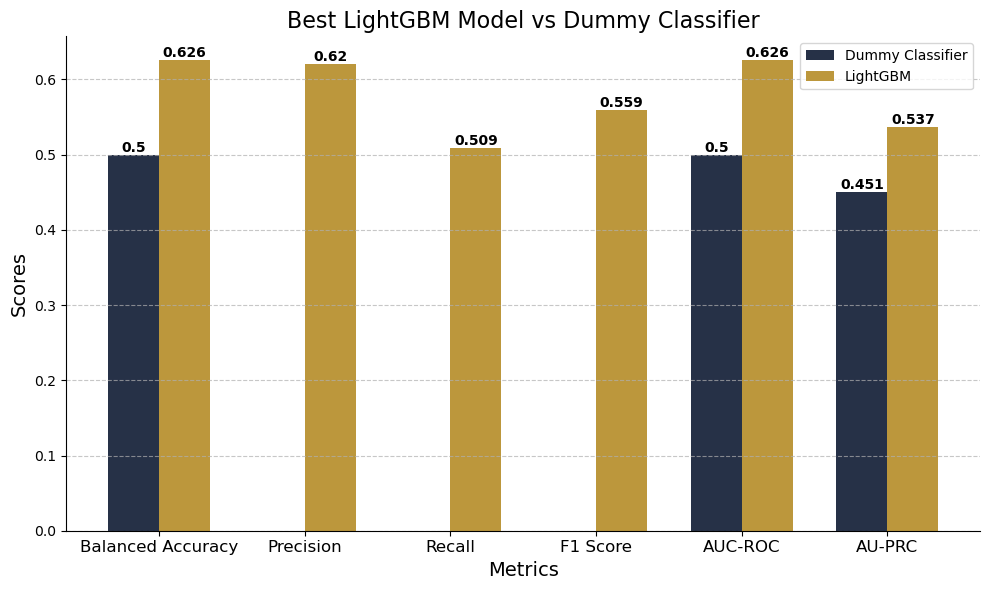

In [876]:
# Define the number of metrics and models
metrics = final_results.columns
models = final_results.index

# Set up the bar width and positions
bar_width = 0.35
r1 = range(len(metrics))
r2 = [x + bar_width for x in r1]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each model
bars1 = ax.bar(r1, final_results.loc['Dummy Classifier'], color='#263147', width=bar_width, label='Dummy Classifier')
bars2 = ax.bar(r2, final_results.loc['LightGBM'], color='#bc973c', width=bar_width, label='LightGBM')

# Add labels, title, and legend
ax.set_xlabel('Metrics', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Best LightGBM Model vs Dummy Classifier', fontsize=16)
ax.set_xticks([r + bar_width / 2 for r in r1])
ax.set_xticklabels(metrics, rotation=0, ha='center', fontsize=12)
ax.legend()

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with the values
def add_value_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        if yval != 0:
            ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:}', ha='center', va='bottom', fontsize=10, fontweight='bold')

add_value_labels(bars1)
add_value_labels(bars2)

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.savefig('p_values.png', dpi=300, bbox_inches='tight', pad_inches=0.1)


## Feature importance (on training data)

In [ ]:
features_used = numerical_features + nominal_features + ordinal_features

# Retrain the best model as we didn't save it after grid search
best_model = LGBMClassifier(n_estimators=200,
                            learning_rate=0.1,
                            max_depth= 25,
                            min_child_samples=100,
                            num_leaves=100,
                            subsample=0.6,
                            colsample_bytree=0.7,
                            n_jobs=-1)

best_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('clf', best_model)])
best_pipeline.fit(X_train, y_train)

results = permutation_importance(best_pipeline, X_train[features_used], y_train, scoring='accuracy', n_repeats=10, random_state=42)

# Extract importances
importances = results.importances_mean
std = results.importances_std

# Create a DataFrame to store feature importances
importances_df = pd.DataFrame({
    'Feature': X_train[features_used].columns,
    'Importance': importances,
    'Std': std
}).sort_values(by='Importance', ascending=True)

print(importances_df)

<Figure size 800x600 with 0 Axes>

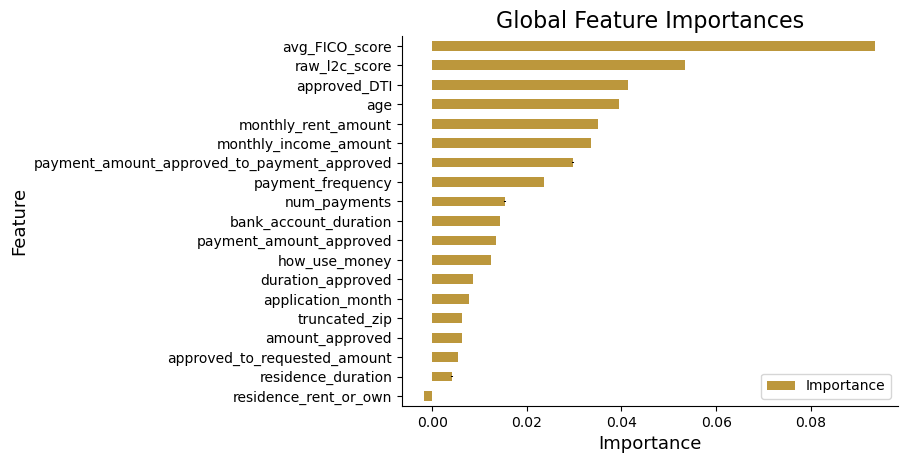

In [944]:
# Plot the importances
plt.figure(figsize=(8, 6))
importances_df.plot(kind='barh', x='Feature', y='Importance', yerr='Std', color='#bc973c')

plt.title('Global Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=13)
plt.ylabel('Feature', fontsize=13)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save the plot
plt.savefig('global_feature_importances.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

Let's try to drop the 4 least important features (bank_account_direct_deposit, home_phone_type, application_day_of_week, email_duration) and see if this improves the predictive power.
Result: it has led to the same performances, so those features were indeed not important, and we can drop them.

Note: since we have highly correlated features (cf EDA), we should not blindly trust the previous FI.
Instead, we could use the approach outlined in [Permutation Importance with Multicollinear or Correlated Features](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py)

In [919]:
model = best_pipeline.named_steps['clf']
importances = model.booster_.feature_importance(importance_type='gain')  # 'split' or 'gain'
feature_names = model.feature_name_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

In [920]:
model = best_pipeline.named_steps['clf']
importances = model.booster_.feature_importance(importance_type='split')  # 'split' or 'gain'
feature_names = model.feature_name_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


## Test set evaluation and final predictions

In [950]:
print(best_pipeline.classes_)

[0 1]


In [955]:
len(X_test)

122

In [953]:
# Make predictions
y_pred = best_pipeline.predict(X_test)
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]  # Ensure correct index for the positive class

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)
au_prc = average_precision_score(y_test, y_pred_proba)

# Store results in a DataFrame
test_results_df = pd.DataFrame([{
    'Model': 'LightGBM',
    'Balanced Accuracy': round(balanced_accuracy, 3),
    'Precision': round(precision, 3),
    'Recall': round(recall, 3),
    'F1 Score': round(f1, 3),
    'AUC-ROC': round(auc_roc, 3),
    'AU-PRC': round(au_prc, 3)
}])

test_results_df

,Model,Balanced Accuracy,Precision,Recall,F1 Score,AUC-ROC,AU-PRC
0,LightGBM,0.58,0.553,0.473,0.51,0.634,0.551


In [958]:
y_pred_proba

array([0.57637402, 0.46509295, 0.36501433, 0.22706547, 0.15549802,
       0.50582175, 0.37590632, 0.26290073, 0.12406132, 0.14385511,
       0.74680138, 0.2901699 , 0.34063313, 0.17693063, 0.21806162,
       0.18090236, 0.22588493, 0.65284295, 0.19879448, 0.39675066,
       0.52960402, 0.45209952, 0.32491152, 0.72783622, 0.59013627,
       0.27444757, 0.4646354 , 0.65727108, 0.77091831, 0.57900655,
       0.20823174, 0.59032514, 0.63633232, 0.33065232, 0.2844514 ,
       0.2703828 , 0.31640727, 0.42468559, 0.67578235, 0.52016166,
       0.23372598, 0.26684786, 0.52443998, 0.26792588, 0.41650853,
       0.292026  , 0.37068395, 0.53398586, 0.52294494, 0.541203  ,
       0.61198321, 0.40404961, 0.178183  , 0.69414098, 0.29732646,
       0.34001413, 0.73102641, 0.67266149, 0.65326993, 0.7203088 ,
       0.28661458, 0.69543184, 0.47329026, 0.61161734, 0.25655626,
       0.4985696 , 0.70782256, 0.22728033, 0.28502048, 0.47723689,
       0.82566469, 0.57126332, 0.23354816, 0.39712364, 0.53855

In [954]:
final_results

,Balanced Accuracy,Precision,Recall,F1 Score,AUC-ROC,AU-PRC
Model,,,,,,
Dummy Classifier,0.500,0.00,0.000,0.000,0.500,0.451
LightGBM,0.626,0.62,0.509,0.559,0.626,0.537


In [962]:
y_pred_proba = best_pipeline.predict_proba(X_test)

# Extract the max predicted probability for the predicted class
max_proba = [y_pred_proba[i, pred] for i, pred in enumerate(y_pred)]

# Create a DataFrame with true labels, max predicted probability, and binary predictions
test_preds_df = pd.DataFrame({
    'predicted_probability': max_proba,
    'predicted_label': y_pred,
    'true_label': y_test # Ensure y_test is a numpy array or a pandas Series
})

In [967]:
test_preds_df.iloc[50:60]

,predicted_probability,predicted_label,true_label
50,0.611983,1,1
51,0.595950,0,0
52,0.821817,0,0
53,0.694141,1,1
54,0.702674,0,0
55,0.659986,0,1
56,0.731026,1,1
57,0.672661,1,1
58,0.653270,1,1
59,0.720309,1,0
